# Прогнозирование total_quantity через Prophet

In [1]:
!pip install seaborn

You should consider upgrading via the 'c:\users\юни\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [2]:
!pip install statsmodels

You should consider upgrading via the 'c:\users\юни\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [3]:
!pip install tqdm

You should consider upgrading via the 'c:\users\юни\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [4]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
sns.set()

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

%matplotlib inline

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
# ads = pd.read_csv('data/ads.csv', index_col=['Time'], parse_dates=['Time'])

In [7]:
data = pd.read_csv('pandas.data', sep='\t')

In [8]:
data

lagerId          ds  businessId  filialArea_baseline  \
0           1105  2017-01-01           1             238401.0   
1           1105  2017-01-02           1             238401.0   
2           1105  2017-01-03           1             238401.0   
3           1105  2017-01-04           1             238401.0   
4           1105  2017-01-05           1             238401.0   
...          ...         ...         ...                  ...   
1783227   868058  2021-06-23           1             245176.0   
1783228   868058  2021-06-24           1             250774.0   
1783229   868058  2021-06-25           1             250774.0   
1783230   868058  2021-06-26           1             250774.0   
1783231   868058  2021-06-27           1             250774.0   

         filialCount_baseline  QtySales_baseline  AmountSales_baseline  \
0                       146.0               11.0               3735.62   
1                       146.0                6.0               2096.00   
2                       146.0                4.0               1408.00   
3                       146.0                4.0               1392.00   
4                       146.0                3.0               1040.00   
...                       ...                ...                   ...   
1783227                 143.0                2.0                298.00   
1783228                 146.0                9.0               1340.99   
1783229                 146.0               14.0               2078.55   
1783230                 146.0                4.0                596.00   
1783231                 146.0               11.0               1631.54   

         filialArea_activity  filialCount_activity  QtySales_activity  \
0                        0.0                   0.0                0.0   
1                        0.0                   0.0                0.0   
2                        0.0                   0.0                0.0   
3                        0.0                   0.0                0.0   
4                        0.0                   0.0                0.0   
...                      ...                   ...                ...   
1783227                  0.0                   0.0                0.0   
1783228                  0.0                   0.0                0.0   
1783229                  0.0                   0.0                0.0   
1783230                  0.0                   0.0                0.0   
1783231                  0.0                   0.0                0.0   

         AmountSales_activity  StoreQtyDefault  EKT1ID  EKT2ID  EKT3ID  \
0                         0.0            755.0      98      40    5287   
1                         0.0            746.0      98      40    5287   
2                         0.0            743.0      98      40    5287   
3                         0.0            745.0      98      40    5287   
4                         0.0            745.0      98      40    5287   
...                       ...              ...     ...     ...     ...   
1783227                   0.0            858.0      98      40    5272   
1783228                   0.0            874.0      98      40    5272   
1783229                   0.0            863.0      98      40    5272   
1783230                   0.0            849.0      98      40    5272   
1783231                   0.0            845.0      98      40    5272   

         EKT4ID  EKT5ID  EKT6ID  privatelabel  country  trademark  \
0          5289    5289    5289             0       21       1094   
1          5289    5289    5289             0       21       1094   
2          5289    5289    5289             0       21       1094   
3          5289    5289    5289             0       21       1094   
4          5289    5289    5289             0       21       1094   
...         ...     ...     ...           ...      ...        ...   
1783227    5279    5281    5281             0        7      13924   
1783228    5279    52

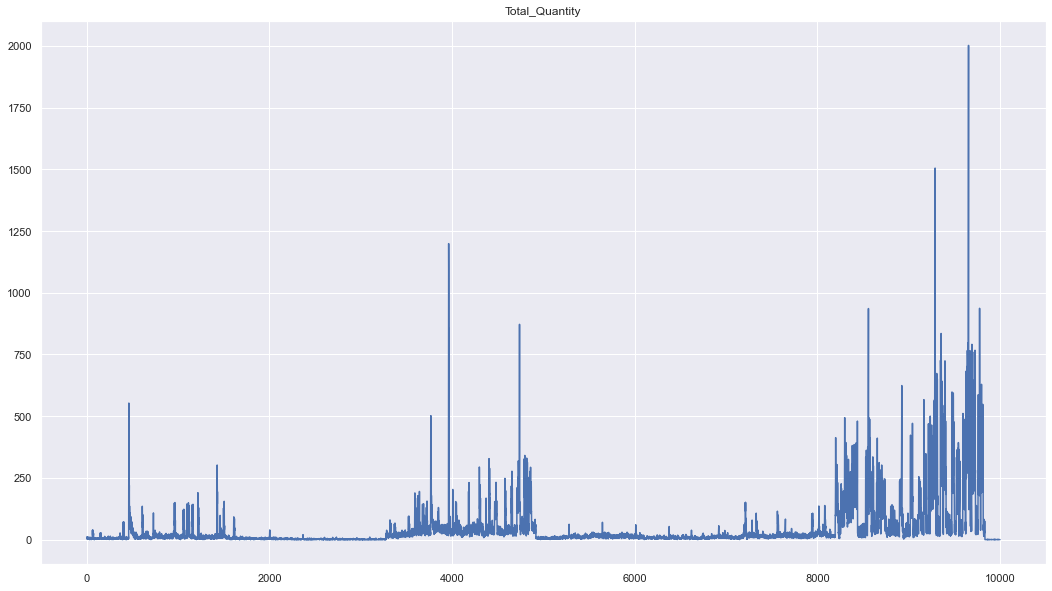

In [9]:
#create time series plot
plt.figure(figsize=(18, 10))
plt.plot(data.total_quantity[:10000])
plt.title('Total_Quantity')
plt.grid(True)
plt.show()

# Исследование данных

## Исследование данных на целостность

In [10]:
data.shape

(1783232, 36)

In [11]:
data.info() #смотрим типы переменных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1783232 entries, 0 to 1783231
Data columns (total 36 columns):
 #   Column                Dtype  
---  ------                -----  
 0   lagerId               int64  
 1   ds                    object 
 2   businessId            int64  
 3   filialArea_baseline   float64
 4   filialCount_baseline  float64
 5   QtySales_baseline     float64
 6   AmountSales_baseline  float64
 7   filialArea_activity   float64
 8   filialCount_activity  float64
 9   QtySales_activity     float64
 10  AmountSales_activity  float64
 11  StoreQtyDefault       float64
 12  EKT1ID                int64  
 13  EKT2ID                int64  
 14  EKT3ID                int64  
 15  EKT4ID                int64  
 16  EKT5ID                int64  
 17  EKT6ID                int64  
 18  privatelabel          int64  
 19  country               int64  
 20  trademark             int64  
 21  importFozzy           float64
 22  CSB                   int64  
 23  PQS    

In [12]:
data.isnull().sum()  # посмотрим на то есть ли в переменных пропуски

lagerId                       0
ds                            0
businessId                    0
filialArea_baseline           0
filialCount_baseline          0
QtySales_baseline             0
AmountSales_baseline          0
filialArea_activity           0
filialCount_activity          0
QtySales_activity             0
AmountSales_activity          0
StoreQtyDefault          605117
EKT1ID                        0
EKT2ID                        0
EKT3ID                        0
EKT4ID                        0
EKT5ID                        0
EKT6ID                        0
privatelabel                  0
country                       0
trademark                     0
importFozzy              208153
CSB                           0
PQS                        1639
Demand                   329439
lagerUnitQuantity             0
lagerGoldTypeId               0
holidayId               1531904
priceBefore             1628869
priceAction             1630128
avg_price_baseline            0
avg_pric

In [13]:
 data[data['StoreQtyDefault'].isna()]

lagerId          ds  businessId  filialArea_baseline  \
16390       4346  2017-01-01           1                  0.0   
16391       4346  2017-01-02           1                  0.0   
16392       4346  2017-01-03           1                  0.0   
16393       4346  2017-01-04           1                  0.0   
16394       4346  2017-01-05           1                  0.0   
...          ...         ...         ...                  ...   
1783219   868058  2021-06-15           1                  0.0   
1783220   868058  2021-06-16           1                  0.0   
1783221   868058  2021-06-17           1                  0.0   
1783222   868058  2021-06-18           1                  0.0   
1783223   868058  2021-06-19           1                  0.0   

         filialCount_baseline  QtySales_baseline  AmountSales_baseline  \
16390                     0.0                0.0                   0.0   
16391                     0.0                0.0                   0.0   
16392                     0.0                0.0                   0.0   
16393                     0.0                0.0                   0.0   
16394                     0.0                0.0                   0.0   
...                       ...                ...                   ...   
1783219                   0.0                0.0                   0.0   
1783220                   0.0                0.0                   0.0   
1783221                   0.0                0.0                   0.0   
1783222                   0.0                0.0                   0.0   
1783223                   0.0                0.0                   0.0   

         filialArea_activity  filialCount_activity  QtySales_activity  \
16390                    0.0                   0.0                0.0   
16391                    0.0                   0.0                0.0   
16392                    0.0                   0.0                0.0   
16393                    0.0                   0.0                0.0   
16394                    0.0                   0.0                0.0   
...                      ...                   ...                ...   
1783219                  0.0                   0.0                0.0   
1783220                  0.0                   0.0                0.0   
1783221                  0.0                   0.0                0.0   
1783222                  0.0                   0.0                0.0   
1783223                  0.0                   0.0                0.0   

         AmountSales_activity  StoreQtyDefault  EKT1ID  EKT2ID  EKT3ID  \
16390                     0.0              NaN      98      40    5272   
16391                     0.0              NaN      98      40    5272   
16392                     0.0              NaN      98      40    5272   
16393                     0.0              NaN      98      40    5272   
16394                     0.0              NaN      98      40    5272   
...                       ...              ...     ...     ...     ...   
1783219                   0.0              NaN      98      40    5272   
1783220                   0.0              NaN      98      40    5272   
1783221                   0.0              NaN      98      40    5272   
1783222                   0.0              NaN      98      40    5272   
1783223                   0.0              NaN      98      40    5272   

         EKT4ID  EKT5ID  EKT6ID  privatelabel  country  trademark  \
16390      5280    6022    6022             0        7       4296   
16391      5280    6022    6022             0        7       4296   
16392      5280    6022    6022             0        7       4296   
16393      5280    6022    6022             0        7       4296   
16394      5280    6022    6022             0        7       4296   
...         ...     ...     ...           ...      ...        ...   
1783219    5279    5281    5281             0        7      13924   
1783220    5279    52

### Вывод 1: столбцы, нуждающиеся в коррекции 
#### StoreQtyDefault - 0.339
#### importFozzy - 0.116
#### PQS - 0.000919
#### Demand -  0.184

### Самые проблемные столбцы

#### holidayId -  0.859
#### priceBefore - 0.913
#### priceAction - 0.914

In [14]:
data['StoreQtyDefault']

0          755.0
1          746.0
2          743.0
3          745.0
4          745.0
           ...  
1783227    858.0
1783228    874.0
1783229    863.0
1783230    849.0
1783231    845.0
Name: StoreQtyDefault, Length: 1783232, dtype: float64

In [15]:
data.isnull().sum()/data.shape[0]

lagerId                 0.000000
ds                      0.000000
businessId              0.000000
filialArea_baseline     0.000000
filialCount_baseline    0.000000
QtySales_baseline       0.000000
AmountSales_baseline    0.000000
filialArea_activity     0.000000
filialCount_activity    0.000000
QtySales_activity       0.000000
AmountSales_activity    0.000000
StoreQtyDefault         0.339337
EKT1ID                  0.000000
EKT2ID                  0.000000
EKT3ID                  0.000000
EKT4ID                  0.000000
EKT5ID                  0.000000
EKT6ID                  0.000000
privatelabel            0.000000
country                 0.000000
trademark               0.000000
importFozzy             0.116728
CSB                     0.000000
PQS                     0.000919
Demand                  0.184743
lagerUnitQuantity       0.000000
lagerGoldTypeId         0.000000
holidayId               0.859060
priceBefore             0.913436
priceAction             0.914142
avg_price_

### Так как пропуски в данных составляют больше 10% то отбрасывать их не целесообразно

## Статистика проблемных столбцов

In [16]:
stats = data[['StoreQtyDefault', 'importFozzy', 'PQS', 'Demand', 'holidayId', 'priceBefore', 'priceAction']]

In [17]:
stats

StoreQtyDefault  importFozzy  PQS  Demand  holidayId  priceBefore  \
0                  755.0          NaN  3.0   110.0        1.0          NaN   
1                  746.0          NaN  3.0   110.0        1.0          NaN   
2                  743.0          NaN  3.0   110.0        NaN          NaN   
3                  745.0          NaN  3.0   110.0        2.0          NaN   
4                  745.0          NaN  3.0   110.0        2.0          NaN   
...                  ...          ...  ...     ...        ...          ...   
1783227            858.0          0.0  4.0     NaN        NaN          NaN   
1783228            874.0          0.0  4.0     NaN        NaN          NaN   
1783229            863.0          0.0  4.0     NaN        NaN          NaN   
1783230            849.0          0.0  4.0     NaN        NaN          NaN   
1783231            845.0          0.0  4.0     NaN        NaN          NaN   

         priceAction  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  
...              ...  
1783227          NaN  
1783228          NaN  
1783229          NaN  
1783230          NaN  
1783231          NaN  

[1783232 rows x 7 columns]

In [18]:
pd.options.display.float_format ='{:,.3f}'.format

In [19]:
stats.describe()

StoreQtyDefault   importFozzy           PQS        Demand   holidayId  \
count    1,178,115.000 1,575,079.000 1,781,593.000 1,453,793.000 251,328.000   
mean           651.166         0.814         2.685       246.299       4.684   
std          1,173.975         0.389         0.791       221.474       2.572   
min             -4.000         0.000         1.000       107.000       1.000   
25%             55.000         1.000         2.000       108.000       2.000   
50%            237.000         1.000         3.000       110.000       4.000   
75%            810.000         1.000         3.000       357.000       7.000   
max         62,666.000         1.000         4.000       776.000       9.000   

       priceBefore  priceAction  
count  154,363.000  153,104.000  
mean       489.801      373.910  
std        437.812      338.356  
min         27.990       19.990  
25%        259.000      199.000  
50%        410.000      319.000  
75%        600.000      449.990  
max     12,494.500    9,999.000

### Столбцы заменяем на:
#### Demand - mean
#### holidayId - 0
#### priceBefore - mean
#### priceAction - mean

## Исследуем категариальные переменные

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1783232 entries, 0 to 1783231
Data columns (total 36 columns):
 #   Column                Dtype  
---  ------                -----  
 0   lagerId               int64  
 1   ds                    object 
 2   businessId            int64  
 3   filialArea_baseline   float64
 4   filialCount_baseline  float64
 5   QtySales_baseline     float64
 6   AmountSales_baseline  float64
 7   filialArea_activity   float64
 8   filialCount_activity  float64
 9   QtySales_activity     float64
 10  AmountSales_activity  float64
 11  StoreQtyDefault       float64
 12  EKT1ID                int64  
 13  EKT2ID                int64  
 14  EKT3ID                int64  
 15  EKT4ID                int64  
 16  EKT5ID                int64  
 17  EKT6ID                int64  
 18  privatelabel          int64  
 19  country               int64  
 20  trademark             int64  
 21  importFozzy           float64
 22  CSB                   int64  
 23  PQS    

In [21]:
cat_variables = data[['lagerId',
                      'businessId',
                      'EKT1ID',
                      'EKT2ID',
                      'EKT3ID',
                      'EKT4ID',
                      'EKT5ID',
                      'EKT6ID',
                      'privatelabel',
                      'country',
                      'trademark',
                      'CSB',
                      'lagerGoldTypeId'
                     ]]

In [22]:
cat_variables

lagerId  businessId  EKT1ID  EKT2ID  EKT3ID  EKT4ID  EKT5ID  EKT6ID  \
0           1105           1      98      40    5287    5289    5289    5289   
1           1105           1      98      40    5287    5289    5289    5289   
2           1105           1      98      40    5287    5289    5289    5289   
3           1105           1      98      40    5287    5289    5289    5289   
4           1105           1      98      40    5287    5289    5289    5289   
...          ...         ...     ...     ...     ...     ...     ...     ...   
1783227   868058           1      98      40    5272    5279    5281    5281   
1783228   868058           1      98      40    5272    5279    5281    5281   
1783229   868058           1      98      40    5272    5279    5281    5281   
1783230   868058           1      98      40    5272    5279    5281    5281   
1783231   868058           1      98      40    5272    5279    5281    5281   

         privatelabel  country  trademark  CSB  lagerGoldTypeId  
0                   0       21       1094  267                1  
1                   0       21       1094  267                1  
2                   0       21       1094  267                1  
3                   0       21       1094  267                1  
4                   0       21       1094  267                1  
...               ...      ...        ...  ...              ...  
1783227             0        7      13924  669                1  
1783228             0        7      13924  669                1  
1783229             0        7      13924  669                1  
1783230             0        7      13924  669                1  
1783231             0        7      13924  669                1  

[1783232 rows x 13 columns]

In [23]:
cat_variables.shape

(1783232, 13)

In [24]:
#Дополнительная проверка на нули в категориальных переменных
cat_variables.isnull().sum()

lagerId            0
businessId         0
EKT1ID             0
EKT2ID             0
EKT3ID             0
EKT4ID             0
EKT5ID             0
EKT6ID             0
privatelabel       0
country            0
trademark          0
CSB                0
lagerGoldTypeId    0
dtype: int64

#### В категориальных переменных нулей нет - это хорошо))

## Смотрим содержиме кат. переменных (имя - количество, %)

### lagerId

In [25]:
cat_variables['lagerId'].value_counts(normalize=True)

728417   0.001
702411   0.001
664549   0.001
702409   0.001
825101   0.001
          ... 
16738    0.001
522645   0.001
522644   0.001
719923   0.001
590557   0.001
Name: lagerId, Length: 1088, dtype: float64

### businessId

In [26]:
cat_variables['businessId'].value_counts(normalize=True)

1   1.000
Name: businessId, dtype: float64

### EKT1ID

In [27]:
cat_variables['EKT1ID'].value_counts(normalize=True)

98   1.000
Name: EKT1ID, dtype: float64

### EKT2ID

In [28]:
cat_variables['EKT2ID'].value_counts(normalize=True)

40   1.000
Name: EKT2ID, dtype: float64

### EKT3ID

In [29]:
cat_variables['EKT3ID'].value_counts(normalize=True)

5287   0.526
5272   0.473
5273   0.001
Name: EKT3ID, dtype: float64

### EKT4ID

In [30]:
cat_variables['EKT4ID'].value_counts(normalize=True)

5280   0.372
5289   0.183
5293   0.129
5279   0.101
5291   0.074
5290   0.072
5295   0.061
5292   0.008
8665   0.001
Name: EKT4ID, dtype: float64

### EKT5ID

In [31]:
cat_variables['EKT5ID'].value_counts(normalize=True)

6022   0.327
5289   0.183
5293   0.129
8266   0.074
5291   0.074
5290   0.072
5295   0.061
6125   0.045
5281   0.027
5292   0.008
8665   0.001
Name: EKT5ID, dtype: float64

### EKT6ID

In [32]:
cat_variables['EKT6ID'].value_counts(normalize=True)

6022   0.327
5289   0.183
5293   0.129
8266   0.074
5291   0.074
5290   0.072
5295   0.061
6125   0.045
5281   0.027
5292   0.008
8665   0.001
Name: EKT6ID, dtype: float64

### privatelabel

In [33]:
cat_variables['privatelabel'].value_counts(normalize=True)

0   1.000
Name: privatelabel, dtype: float64

### country

In [34]:
cat_variables['country'].value_counts(normalize=True)

7     0.328
61    0.152
6     0.097
21    0.081
8     0.076
31    0.051
27    0.040
9     0.019
33    0.018
122   0.017
29    0.015
130   0.015
58    0.009
99    0.009
72    0.006
80    0.006
102   0.005
150   0.005
157   0.005
20    0.004
5     0.004
153   0.004
246   0.004
254   0.004
1     0.003
108   0.003
86    0.003
74    0.003
201   0.003
173   0.003
42    0.002
22    0.002
206   0.001
75    0.001
192   0.001
156   0.001
129   0.001
17    0.001
263   0.001
Name: country, dtype: float64

### trademark

In [35]:
cat_variables['trademark'].value_counts(normalize=True)

2353    0.019
14151   0.017
1231    0.017
4965    0.016
4972    0.016
         ... 
15049   0.001
5842    0.001
1748    0.001
15677   0.001
12046   0.001
Name: trademark, Length: 373, dtype: float64

### CSB

In [36]:
cat_variables['CSB'].value_counts(normalize=True)

4118   0.117
270    0.084
267    0.076
2104   0.058
251    0.051
4125   0.051
235    0.047
476    0.047
1072   0.047
240    0.042
670    0.032
2618   0.029
669    0.028
2103   0.026
268    0.026
2099   0.024
260    0.024
3985   0.022
2100   0.020
1074   0.018
2390   0.018
2619   0.016
264    0.016
2620   0.016
4138   0.015
3986   0.012
668    0.012
4132   0.012
4110   0.008
1429   0.006
Name: CSB, dtype: float64

### lagerGoldTypeId

In [37]:
cat_variables['lagerGoldTypeId'].value_counts(normalize=True)

1   1.000
Name: lagerGoldTypeId, dtype: float64

## Выводы по категориальным переменным:

### Вывод1:

#### переменные, перечисленные ниже, содержат константы и не представляют для прогноза никакой ценности, поэтому, убираем их из итоговой выборки:
#### - businessId
#### - EKT1ID
#### - EKT2ID
#### - privatelabel
#### - lagerGoldTypeId


### Вывод2:

#### категориальные переменные, перечисленные ниже, имеют небольшое кол-во вариаций. Для лучшей работы с линейной моделью - применим для них ф-цию "Гарячего кодирования" (get_dummies или OneHotEncoder):
#### - EKT3ID
#### - EKT4ID
#### - EKT5ID
#### - EKT6ID
#### - country
#### - CSB

### Вывод3:
#### оставшиеся переменные оставим в исходном виде 
#### - lagerId
#### - trademark

## Исследуем некатегариальные переменные

In [38]:
nocat_variables = \
data.drop(labels=cat_variables.columns.values, axis=1).drop(labels=['total_quantity'], axis=1)

In [39]:
nocat_variables

ds  filialArea_baseline  filialCount_baseline  \
0        2017-01-01          238,401.000               146.000   
1        2017-01-02          238,401.000               146.000   
2        2017-01-03          238,401.000               146.000   
3        2017-01-04          238,401.000               146.000   
4        2017-01-05          238,401.000               146.000   
...             ...                  ...                   ...   
1783227  2021-06-23          245,176.000               143.000   
1783228  2021-06-24          250,774.000               146.000   
1783229  2021-06-25          250,774.000               146.000   
1783230  2021-06-26          250,774.000               146.000   
1783231  2021-06-27          250,774.000               146.000   

         QtySales_baseline  AmountSales_baseline  filialArea_activity  \
0                   11.000             3,735.620                0.000   
1                    6.000             2,096.000                0.000   
2                    4.000             1,408.000                0.000   
3                    4.000             1,392.000                0.000   
4                    3.000             1,040.000                0.000   
...                    ...                   ...                  ...   
1783227              2.000               298.000                0.000   
1783228              9.000             1,340.990                0.000   
1783229             14.000             2,078.550                0.000   
1783230              4.000               596.000                0.000   
1783231             11.000             1,631.540                0.000   

         filialCount_activity  QtySales_activity  AmountSales_activity  \
0                       0.000              0.000                 0.000   
1                       0.000              0.000                 0.000   
2                       0.000              0.000                 0.000   
3                       0.000              0.000                 0.000   
4                       0.000              0.000                 0.000   
...                       ...                ...                   ...   
1783227                 0.000              0.000                 0.000   
1783228                 0.000              0.000                 0.000   
1783229                 0.000              0.000                 0.000   
1783230                 0.000              0.000                 0.000   
1783231                 0.000              0.000                 0.000   

         StoreQtyDefault  importFozzy   PQS  Demand  lagerUnitQuantity  \
0                755.000          NaN 3.000 110.000              0.500   
1                746.000          NaN 3.000 110.000              0.500   
2                743.000          NaN 3.000 110.000              0.500   
3                745.000          NaN 3.000 110.000              0.500   
4                745.000          NaN 3.000 110.000              0.500   
...                  ...          ...   ...     ...                ...   
1783227          858.000        0.000 4.000     NaN              0.750   
1783228          874.000        0.000 4.000     NaN              0.750   
1783229          863.000        0.000 4.000     NaN              0.750   
1783230          849.000        0.000 4.000     NaN              0.750   
1783231          845.000        0.000 4.000     NaN              0.750   

         holidayId  priceBefore  priceAction  avg_price_baseline  \
0            1.000          NaN          NaN             339.602   
1            1.000          NaN          NaN             349.333   
2              NaN          NaN          NaN             352.000   
3            2.000          NaN          NaN             348.000   
4            2.000          NaN          NaN             346.667   
...            ...          ...          ...                 ...   
1783227        NaN          NaN          NaN             149.000   
1783228        NaN       

In [40]:
#Проверка, все ли значения float ?
nocat_variables.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1783232 entries, 0 to 1783231
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ds                    object 
 1   filialArea_baseline   float64
 2   filialCount_baseline  float64
 3   QtySales_baseline     float64
 4   AmountSales_baseline  float64
 5   filialArea_activity   float64
 6   filialCount_activity  float64
 7   QtySales_activity     float64
 8   AmountSales_activity  float64
 9   StoreQtyDefault       float64
 10  importFozzy           float64
 11  PQS                   float64
 12  Demand                float64
 13  lagerUnitQuantity     float64
 14  holidayId             float64
 15  priceBefore           float64
 16  priceAction           float64
 17  avg_price_baseline    float64
 18  avg_price_promo       float64
 19  discount              float64
 20  total_sales_area      float64
 21  total_sales_count     float64
dtypes: float64(21), object(1)
memory usage: 29

In [41]:
nocat_variables.shape

(1783232, 22)

## Выводим статистику по некатегориальным переменнымм 

In [42]:
nocat_variables.describe(percentiles = [.25, .50, .75, .90, .95, .99, .999])

filialArea_baseline  filialCount_baseline  QtySales_baseline  \
count        1,783,232.000         1,783,232.000      1,783,232.000   
mean            70,626.180                38.977              5.246   
std            105,063.810                64.942             19.558   
min                  0.000                 0.000              0.000   
25%                  0.000                 0.000              0.000   
50%              8,151.000                 4.000              0.000   
75%            109,066.000                48.000              2.000   
90%            252,951.000               143.000             12.000   
95%            316,277.450               205.000             29.000   
99%            376,321.000               252.000             89.000   
99.9%          422,028.000               289.000            229.769   
max            445,440.000               310.000          3,345.000   

       AmountSales_baseline  filialArea_activity  filialCount_activity  \
count         1,783,232.000        1,783,232.000         1,783,232.000   
mean              1,107.559           21,697.893                12.450   
std               3,642.599           70,828.787                43.794   
min                   0.000                0.000                 0.000   
25%                   0.000                0.000                 0.000   
50%                   0.000                0.000                 0.000   
75%                 669.000                0.000                 0.000   
90%               2,969.050           47,533.000                18.000   
95%               5,708.989          208,337.000               107.000   
99%              16,687.624          346,642.000               232.000   
99.9%            40,906.576          412,505.000               281.000   
max             426,656.780          440,788.000               305.000   

       QtySales_activity  AmountSales_activity  StoreQtyDefault   importFozzy  \
count      1,783,232.000         1,783,232.000    1,178,115.000 1,575,079.000   
mean               5.501             1,134.665          651.166         0.814   
std               44.989             8,459.032        1,173.975         0.389   
min                0.000                 0.000           -4.000         0.000   
25%                0.000                 0.000           55.000         1.000   
50%                0.000                 0.000          237.000         1.000   
75%                0.000                 0.000          810.000         1.000   
90%                0.000                 0.000        1,826.000         1.000   
95%               16.000             3,810.395        2,529.000         1.000   
99%              129.000            27,399.299        4,542.000         1.000   
99.9%            642.000           115,538.092       11,223.544         1.000   
max            4,751.000           873,118.360       62,666.000         1.000   

                PQS        Demand  lagerUnitQuantity   holidayId  priceBefore  \
count 1,781,593.000 1,453,793.000      1,783,232.000 251,328.000  154,363.000   
mean          2.685       246.299              0.716       4.684      489.801   
std           0.791       221.474              0.247       2.572      437.812   
min           1.000       107.000              0.040       1.000       27.990   
25%           2.000       108.000              0.700       2.000      259.000   
50%           3.000       110.000              0.750       4.000      410.000   
75%           3.000       357.000              0.750       7.000      600.000   
90%           4.000       610.000              0.750       8.000      894.000   
95%           4.000       776.000              1.000       9.000    1,140.000   
99%           4.000       776.000              1.000       9.000    1,699.000   
99.9%         4.000       776.000              3.000       9.000    6,813.000   
max           4.000       776.000              6.000       9.000   12,494.500   

       price

In [43]:
data['total_quantity'].describe(percentiles = [.25, .50, .75, .90, .95, .99, .999])

count   1,783,232.000
mean           10.748
std            48.853
min             0.000
25%             0.000
50%             0.000
75%             4.000
90%            24.900
95%            52.000
99%           168.000
99.9%         655.000
max         4,831.000
Name: total_quantity, dtype: float64

### Построим гистораммы распределения исходных некатегориальных переменных

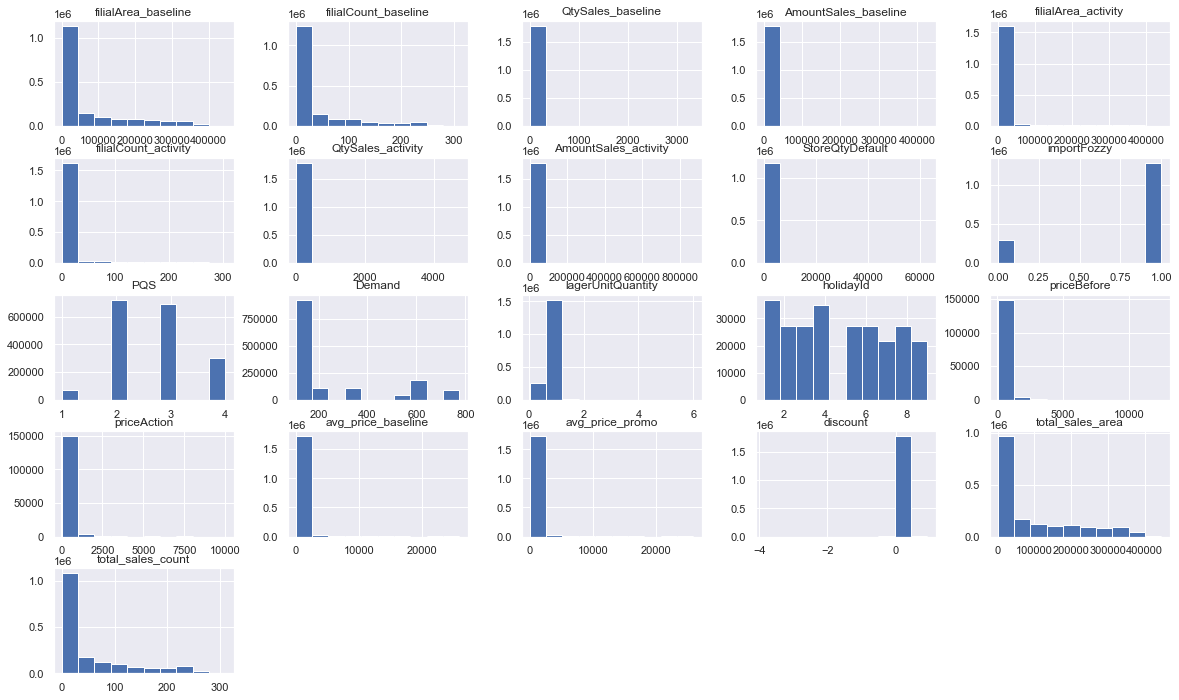

In [44]:
nocat_variables.hist(figsize=(20, 12));

### Вывод:
#### большинство данных имеют выбросы и распределение, отличное от "нормального"
#### Возможно придется логарифмировать данные

### Построим корреляционную матрицу. Визуально определим:
#### - линейные связи переменных с целевой переменной
#### - линейные связи переменных между собой

In [45]:
nocat_add_target = data.drop(labels=cat_variables.columns.values, axis=1)

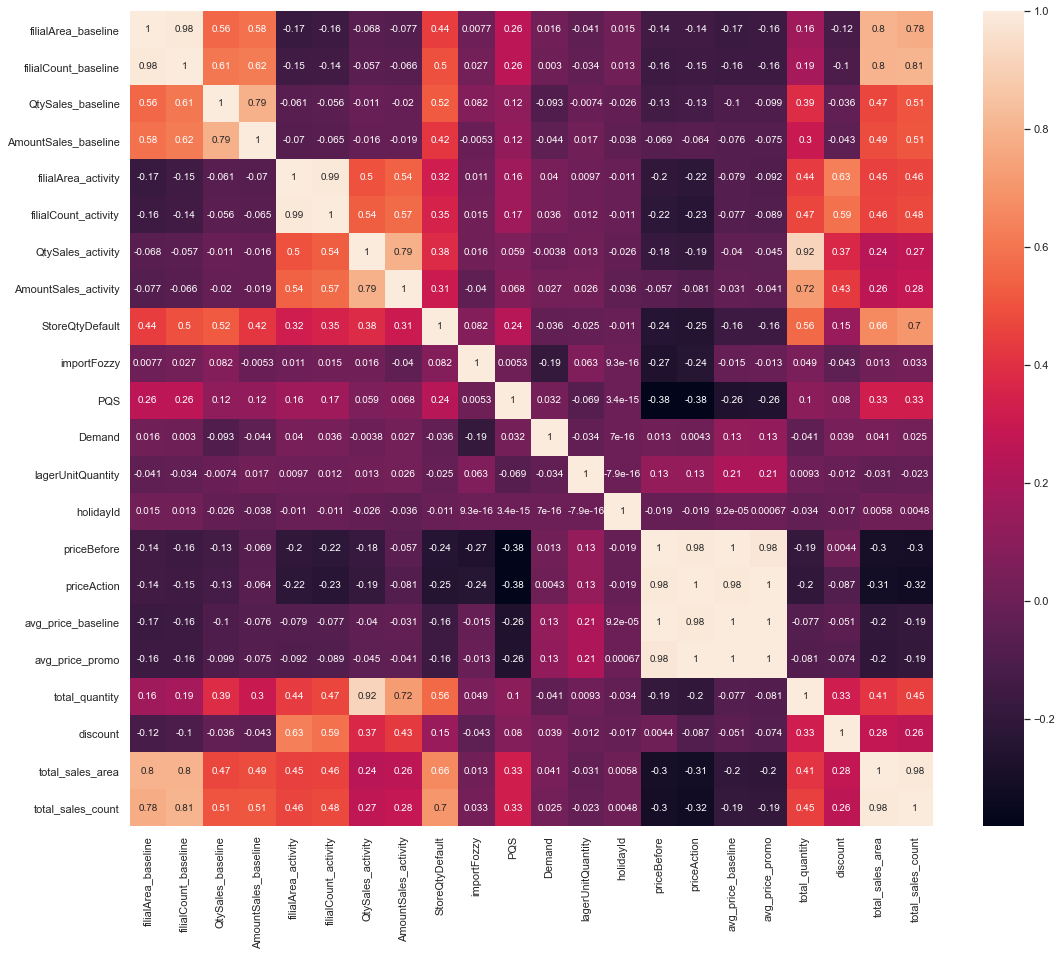

In [46]:
plt.figure(figsize=(18, 15))
sns.heatmap(nocat_add_target.corr(), annot=True, xticklabels='auto');

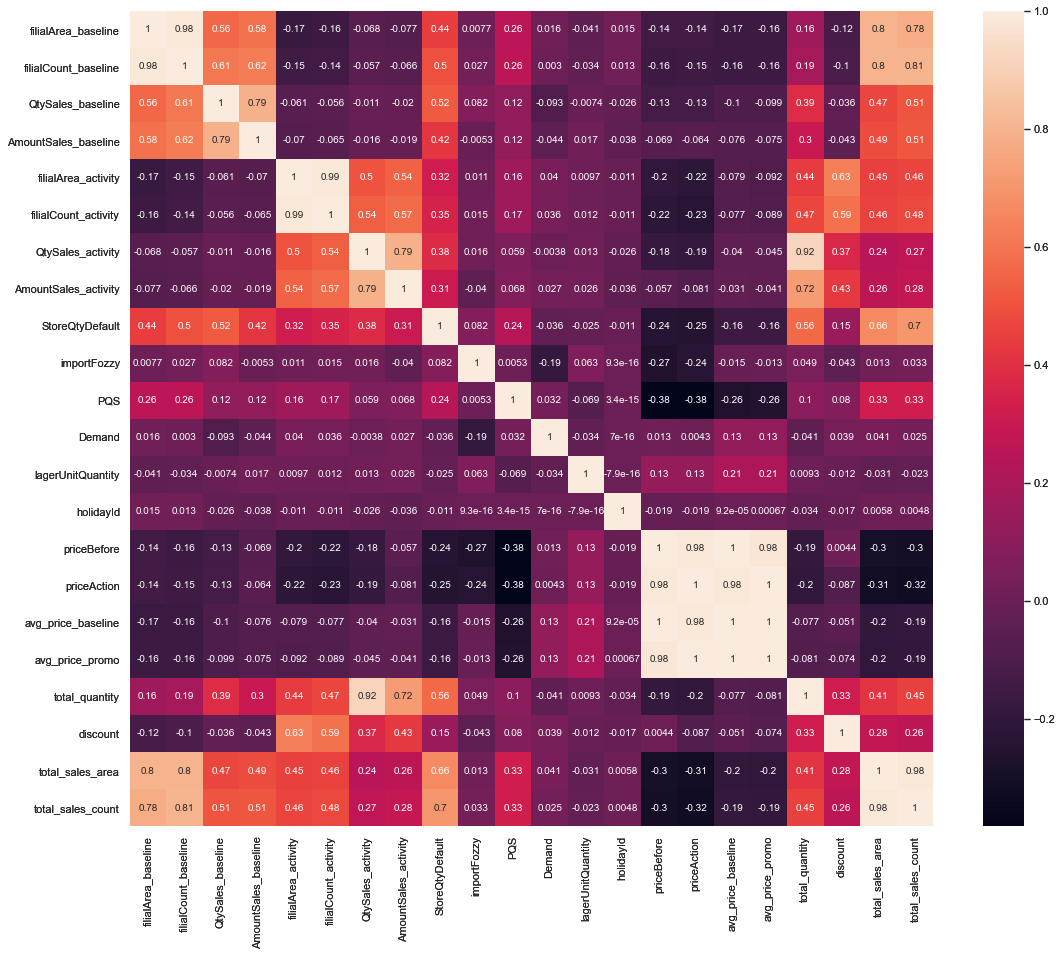

In [47]:
from IPython.display import Image
Image("help_notebooks/corr_matrix.jpg")

### total_quantity - четвертая строка снизу ))))

### Вывод: 
####  как мы видим, total_quantity имеет явную линейную корреляцию с QtySales_activity и AmountSales_activity. Эти параметры олично линейно описывают целевую переменную.

### Построим 'облако рассеивания' (pairplot). Визуально определим:¶
#### - линейные и нелинейные связи переменных с целевой переменной
#### - линейные и нелинейные связи переменных между собой

In [48]:
# sns.pairplot(nocat_add_target[['total_quantity', 'QtySales_activity', 'AmountSales_activity']])

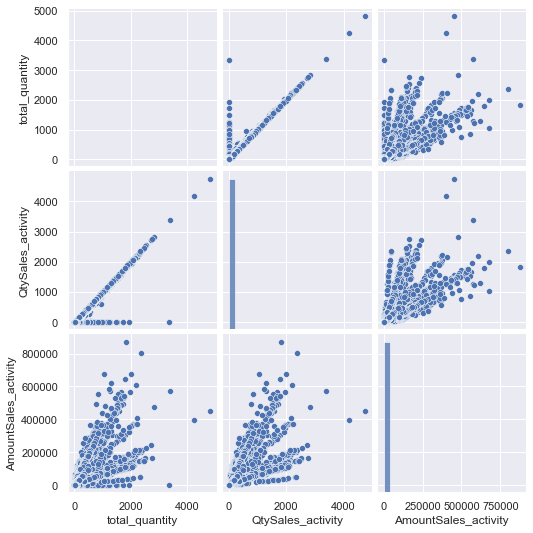

In [49]:
Image("help_notebooks/pairplot.jpg")

### Вывод: 
####  как мы можем видеть, total_quantity имеет явную линейную корреляцию с QtySales_activity и AmountSales_activity. Эти параметры олично линейно описывают целевую переменную, при условии их независимого от целевой переменной, измерения.

In [50]:
#Построим ранг корреляций целевой переменной в порядке убывания
nocat_add_target.corr()['total_quantity'].sort_values(ascending = False)

total_quantity          1.000
QtySales_activity       0.916
AmountSales_activity    0.721
StoreQtyDefault         0.563
filialCount_activity    0.471
total_sales_count       0.451
filialArea_activity     0.438
total_sales_area        0.413
QtySales_baseline       0.390
discount                0.325
AmountSales_baseline    0.301
filialCount_baseline    0.190
filialArea_baseline     0.161
PQS                     0.101
importFozzy             0.049
lagerUnitQuantity       0.009
holidayId              -0.034
Demand                 -0.041
avg_price_baseline     -0.077
avg_price_promo        -0.081
priceBefore            -0.188
priceAction            -0.201
Name: total_quantity, dtype: float64

# Построение прогнозной модели

## Метрики качества прогноза

- [R squared](http://scikit-learn.org/stable/modules/model_evaluation.html#r2-score-the-coefficient-of-determination), коэффициент детерминации (в эконометрике - доля объясненной моделью дисперсии), $(-\infty, 1]$

$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$ 

```python
sklearn.metrics.r2_score
```
---
- [Mean Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error), интерпретируемая метрика, измеряется в тех же единицах, что и исходный ряд, $[0, +\infty)$

$MAE = \frac{\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|}{n}$ 

```python
sklearn.metrics.mean_absolute_error
```
---
- [Median Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#median-absolute-error), также интерпретируемая метрика, однако её преимущество - нечувствительность (робастность) к выбросам в данных, $[0, +\infty)$

$MedAE = median(|y_1 - \hat{y}_1|, ... , |y_n - \hat{y}_n|)$

```python
sklearn.metrics.median_absolute_error
```
---
- [Mean Squared Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error), используется в большинстве случаев, сильнее наказывает модель за большие ошибки и меньше - за маленькие (парабола), $[0, +\infty)$

$MSE = \frac{1}{n}\sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2$

```python
sklearn.metrics.mean_squared_error
```
---
- [Mean Squared Logarithmic Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-logarithmic-error), практически тоже самое, но значения предварительно логарифмируются, таким образом маленьким ошибкам также уделяется значительное внимание, обычно используется, если данным присущ экспоненциальный рост, $[0, +\infty)$

$MSLE = \frac{1}{n}\sum\limits_{i=1}^{n} (log(1+y_i) - log(1+\hat{y}_i))^2$

```python
sklearn.metrics.mean_squared_log_error
```
---
- Mean Absolute Percentage Error, как MAE, только в процентах, - удобно для объяснения заказчику качества прогноза, $[0, +\infty)$

$MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$ 

```python
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
```

In [51]:
# импортируем всё, о чем говорили выше

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Закинем все метрики в одну общую функцию, чтобы было удобно их печатать. 

In [72]:
def print_metrics_train(y_train,y_pred):
    print('Метрики качества на train')
    print('MAE:', metrics.mean_absolute_error(y_train, y_pred))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, y_pred)))
    print('R2:',  metrics.r2_score(y_train, y_pred))
    print('MAPE:', mean_absolute_percentage_error(y_train, y_pred))
    pass

In [73]:
def print_metrics_test(y_test,y_pred):
    print('Метрики качества на test')
    print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('R2:',  metrics.r2_score(y_test, y_pred))
    print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))
    pass

## Корректируем праздники

In [52]:
holidays_df = data[['holidayId', 'ds']].drop_duplicates().dropna()
holidays_df

holidayId          ds
0         1.000  2017-01-01
1         1.000  2017-01-02
3         2.000  2017-01-04
4         2.000  2017-01-05
5         2.000  2017-01-06
...         ...         ...
1578      6.000  2021-04-28
1579      6.000  2021-04-29
1580      6.000  2021-04-30
1581      6.000  2021-05-01
1582      6.000  2021-05-02

[231 rows x 2 columns]

In [53]:
holidays_df['holiday'] = holidays_df['holidayId'].astype(int).astype(str)

In [54]:
holidays_df['lower_window'] = -1

In [55]:
holidays_df['upper_window'] = 1

In [56]:
holidays_df = holidays_df[holidays_df['holiday'] != '1']

In [57]:
new_year_days = pd.DataFrame({
                              
    'holiday': '777',
    'ds': pd.to_datetime(['2016-12-31',
                          '2017-12-31',
                          '2018-12-31',
                          '2019-12-31',
                          '2020-12-31',
                          '2021-12-31',
                          '2022-12-31',
                          '2023-12-31']),
    'lower_window': -4,
    'upper_window': 2,
})

In [58]:
holidays_df = pd.concat([holidays_df, new_year_days])

In [59]:
holidays_df[holidays_df['holidayId'] != holidays_df['holiday']]

holidayId                   ds holiday  lower_window  upper_window
3       2.000           2017-01-04       2            -1             1
4       2.000           2017-01-05       2            -1             1
5       2.000           2017-01-06       2            -1             1
6       2.000           2017-01-07       2            -1             1
7       2.000           2017-01-08       2            -1             1
..        ...                  ...     ...           ...           ...
3         NaN  2019-12-31 00:00:00     777            -4             2
4         NaN  2020-12-31 00:00:00     777            -4             2
5         NaN  2021-12-31 00:00:00     777            -4             2
6         NaN  2022-12-31 00:00:00     777            -4             2
7         NaN  2023-12-31 00:00:00     777            -4             2

[205 rows x 5 columns]

In [60]:
holidays_df['holiday'].value_counts()

4      32
6      25
2      25
8      25
5      25
3      25
7      20
9      20
777     8
Name: holiday, dtype: int64

## Группируем данные 

In [133]:
data

lagerId          ds  businessId  filialArea_baseline  \
0           1105  2017-01-01           1          238,401.000   
1           1105  2017-01-02           1          238,401.000   
2           1105  2017-01-03           1          238,401.000   
3           1105  2017-01-04           1          238,401.000   
4           1105  2017-01-05           1          238,401.000   
...          ...         ...         ...                  ...   
1783227   868058  2021-06-23           1          245,176.000   
1783228   868058  2021-06-24           1          250,774.000   
1783229   868058  2021-06-25           1          250,774.000   
1783230   868058  2021-06-26           1          250,774.000   
1783231   868058  2021-06-27           1          250,774.000   

         filialCount_baseline  QtySales_baseline  AmountSales_baseline  \
0                     146.000             11.000             3,735.620   
1                     146.000              6.000             2,096.000   
2                     146.000              4.000             1,408.000   
3                     146.000              4.000             1,392.000   
4                     146.000              3.000             1,040.000   
...                       ...                ...                   ...   
1783227               143.000              2.000               298.000   
1783228               146.000              9.000             1,340.990   
1783229               146.000             14.000             2,078.550   
1783230               146.000              4.000               596.000   
1783231               146.000             11.000             1,631.540   

         filialArea_activity  filialCount_activity  QtySales_activity  \
0                      0.000                 0.000              0.000   
1                      0.000                 0.000              0.000   
2                      0.000                 0.000              0.000   
3                      0.000                 0.000              0.000   
4                      0.000                 0.000              0.000   
...                      ...                   ...                ...   
1783227                0.000                 0.000              0.000   
1783228                0.000                 0.000              0.000   
1783229                0.000                 0.000              0.000   
1783230                0.000                 0.000              0.000   
1783231                0.000                 0.000              0.000   

         AmountSales_activity  StoreQtyDefault  EKT1ID  EKT2ID  EKT3ID  \
0                       0.000          755.000      98      40    5287   
1                       0.000          746.000      98      40    5287   
2                       0.000          743.000      98      40    5287   
3                       0.000          745.000      98      40    5287   
4                       0.000          745.000      98      40    5287   
...                       ...              ...     ...     ...     ...   
1783227                 0.000          858.000      98      40    5272   
1783228                 0.000          874.000      98      40    5272   
1783229                 0.000          863.000      98      40    5272   
1783230                 0.000          849.000      98      40    5272   
1783231                 0.000          845.000      98      40    5272   

         EKT4ID  EKT5ID  EKT6ID  privatelabel  country  trademark  \
0          5289    5289    5289             0       21       1094   
1          5289    5289    5289             0       21       1094   
2          5289    5289    5289             0       21       1094   
3          5289    5289    5289             0       21       1094   
4          5289    5289    5289             0       21       1094   
...         ...     ...     ...           ...      ...        ...   
1783227    5279    5281    5281             0        7      13924   
1783228    5279    52

In [134]:
data['lagerId_with_discount'] = np.where(data['discount'] != 0, 1, np.nan)

In [187]:
grouped_data = data[['CSB',
                     'ds',
                     'businessId',
                     'lagerId',
                     'lagerId_with_discount',
                     'discount',
                     'filialArea_baseline',
                     'filialArea_activity',
                     
                     'total_quantity']].groupby(['CSB','ds','businessId']).agg({'lagerId': 'count',
                                                                'lagerId_with_discount': 'count',
                                                                'discount': ['min', 'max', 'mean', 'median', 'std'],
                                                                'filialArea_baseline': ['min', 'max', 'mean', 'median', 'std'],
                                                                'filialArea_activity': ['min', 'max', 'mean', 'median', 'std'],
                                                               
                                                                'total_quantity': 'sum'})
grouped_data

lagerId lagerId_with_discount discount              \
                             count                 count      min   max  mean   
CSB  ds         businessId                                                      
235  2017-01-01 1               51                     0    0.000 0.000 0.000   
     2017-01-02 1               51                     0    0.000 0.000 0.000   
     2017-01-03 1               51                     0    0.000 0.000 0.000   
     2017-01-04 1               51                     0    0.000 0.000 0.000   
     2017-01-05 1               51                     2    0.000 0.294 0.012   
...                            ...                   ...      ...   ...   ...   
4138 2021-06-23 1               16                     3   -0.018 0.251 0.027   
     2021-06-24 1               16                     3   -0.017 0.251 0.027   
     2021-06-25 1               16                     2    0.000 0.201 0.023   
     2021-06-26 1               16                     3   -0.016 0.201 0.012   
     2021-06-27 1               16                     1    0.000 0.201 0.013   

                                        filialArea_baseline              \
                           median   std                 min         max   
CSB  ds         businessId                                                
235  2017-01-01 1           0.000 0.000               0.000 333,678.000   
     2017-01-02 1           0.000 0.000               0.000 333,678.000   
     2017-01-03 1           0.000 0.000               0.000 333,678.000   
     2017-01-04 1           0.000 0.000               0.000 333,678.000   
     2017-01-05 1           0.000 0.058               0.000 333,678.000   
...                           ...   ...                 ...         ...   
4138 2021-06-23 1           0.000 0.078               0.000 380,980.000   
     2021-06-24 1           0.000 0.078               0.000 380,980.000   
     2021-06-25 1           0.000 0.063               0.000 383,321.000   
     2021-06-26 1           0.000 0.051               0.000 383,321.000   
     2021-06-27 1           0.000 0.050               0.000 382,525.000   

                                                                \
                                  mean      median         std   
CSB  ds         businessId                                       
235  2017-01-01 1          161,017.000 172,347.000 156,526.692   
     2017-01-02 1          161,526.294 171,597.000 157,029.138   
     2017-01-03 1          162,187.451 168,748.000 157,788.190   
     2017-01-04 1          162,323.098 166,566.000 157,973.242   
     2017-01-05 1          149,525.627   3,480.000 157,116.652   
...                                ...         ...         ...   
4138 2021-06-23 1           99,741.062  12,337.000 145,912.504   
     2021-06-24 1           99,482.562  12,337.000 145,395.186   
     2021-06-25 1          100,100.875  13,407.500 146,166.919   
     2021-06-26 1          100,070.438  13,407.500 145,908.058   
     2021-06-27 1           99,617.125  13,407.500 145,139.272   

                           filialArea_activity                                \
                                           min         max       mean median   
CSB  ds         businessId                                                     
235  2017-01-01 1                        0.000       0.000      0.000  0.000   
     2017-01-02 1                        0.000       0.000      0.000  0.000   
     2017-01-03 1                        0.000       0.000      0.000  0.000   
     2017-01-04 1                        0.000       0.000      0.000  0.000   
     2017-01-05 1                        0.000 330,198.000 12,948.941  0.000   
...                                        ...         ...        ...    ...   
4138 2021-06-23 1                        0.000 156,248.000 13,077.125  0.000   
     2021-06-24 1                        0.000 149,359.000 12,646.562  0.000   
     2021-06-25 1                   

In [188]:
# Убираем мультииндексы и мультиколонки
grouped_data.columns = ['_'.join(col).strip() for col in grouped_data.columns.values]

In [189]:
grouped_data

lagerId_count  lagerId_with_discount_count  \
CSB  ds         businessId                                               
235  2017-01-01 1                      51                            0   
     2017-01-02 1                      51                            0   
     2017-01-03 1                      51                            0   
     2017-01-04 1                      51                            0   
     2017-01-05 1                      51                            2   
...                                   ...                          ...   
4138 2021-06-23 1                      16                            3   
     2021-06-24 1                      16                            3   
     2021-06-25 1                      16                            2   
     2021-06-26 1                      16                            3   
     2021-06-27 1                      16                            1   

                            discount_min  discount_max  discount_mean  \
CSB  ds         businessId                                              
235  2017-01-01 1                  0.000         0.000          0.000   
     2017-01-02 1                  0.000         0.000          0.000   
     2017-01-03 1                  0.000         0.000          0.000   
     2017-01-04 1                  0.000         0.000          0.000   
     2017-01-05 1                  0.000         0.294          0.012   
...                                  ...           ...            ...   
4138 2021-06-23 1                 -0.018         0.251          0.027   
     2021-06-24 1                 -0.017         0.251          0.027   
     2021-06-25 1                  0.000         0.201          0.023   
     2021-06-26 1                 -0.016         0.201          0.012   
     2021-06-27 1                  0.000         0.201          0.013   

                            discount_median  discount_std  \
CSB  ds         businessId                                  
235  2017-01-01 1                     0.000         0.000   
     2017-01-02 1                     0.000         0.000   
     2017-01-03 1                     0.000         0.000   
     2017-01-04 1                     0.000         0.000   
     2017-01-05 1                     0.000         0.058   
...                                     ...           ...   
4138 2021-06-23 1                     0.000         0.078   
     2021-06-24 1                     0.000         0.078   
     2021-06-25 1                     0.000         0.063   
     2021-06-26 1                     0.000         0.051   
     2021-06-27 1                     0.000         0.050   

                            filialArea_baseline_min  filialArea_baseline_max  \
CSB  ds         businessId                                                     
235  2017-01-01 1                             0.000              333,678.000   
     2017-01-02 1                             0.000              333,678.000   
     2017-01-03 1                             0.000              333,678.000   
     2017-01-04 1                             0.000              333,678.000   
     2017-01-05 1                             0.000              333,678.000   
...                                             ...                      ...   
4138 2021-06-23 1                             0.000              380,980.000   
     2021-06-24 1                             0.000              380,980.000   
     2021-06-25 1                             0.000              383,321.000   
     2021-06-26 1                             0.000              383,321.000   
     2021-06-27 1                             0.000              382,525.000   

                            filialArea_baseline_mean  \
CSB  ds         businessId                             
235  2017-01-01 1                        161,017.000   
     2017-01-02 1                        161,526.294   
     2017-01-03 1                        162,187.451   


In [191]:
grouped_data = grouped_data.reset_index()

In [192]:
grouped_data

CSB          ds  businessId  lagerId_count  \
0       235  2017-01-01           1             51   
1       235  2017-01-02           1             51   
2       235  2017-01-03           1             51   
3       235  2017-01-04           1             51   
4       235  2017-01-05           1             51   
...     ...         ...         ...            ...   
49165  4138  2021-06-23           1             16   
49166  4138  2021-06-24           1             16   
49167  4138  2021-06-25           1             16   
49168  4138  2021-06-26           1             16   
49169  4138  2021-06-27           1             16   

       lagerId_with_discount_count  discount_min  discount_max  discount_mean  \
0                                0         0.000         0.000          0.000   
1                                0         0.000         0.000          0.000   
2                                0         0.000         0.000          0.000   
3                                0         0.000         0.000          0.000   
4                                2         0.000         0.294          0.012   
...                            ...           ...           ...            ...   
49165                            3        -0.018         0.251          0.027   
49166                            3        -0.017         0.251          0.027   
49167                            2         0.000         0.201          0.023   
49168                            3        -0.016         0.201          0.012   
49169                            1         0.000         0.201          0.013   

       discount_median  discount_std  filialArea_baseline_min  \
0                0.000         0.000                    0.000   
1                0.000         0.000                    0.000   
2                0.000         0.000                    0.000   
3                0.000         0.000                    0.000   
4                0.000         0.058                    0.000   
...                ...           ...                      ...   
49165            0.000         0.078                    0.000   
49166            0.000         0.078                    0.000   
49167            0.000         0.063                    0.000   
49168            0.000         0.051                    0.000   
49169            0.000         0.050                    0.000   

       filialArea_baseline_max  filialArea_baseline_mean  \
0                  333,678.000               161,017.000   
1                  333,678.000               161,526.294   
2                  333,678.000               162,187.451   
3                  333,678.000               162,323.098   
4                  333,678.000               149,525.627   
...                        ...                       ...   
49165              380,980.000                99,741.062   
49166              380,980.000                99,482.562   
49167              383,321.000               100,100.875   
49168              383,321.000               100,070.438   
49169              382,525.000                99,617.125   

       filialArea_baseline_median  filialArea_baseline_std  \
0                     172,347.000              156,526.692   
1                     171,597.000              157,029.138   
2                     168,748.000              157,788.190   
3                     166,566.000              157,973.242   
4                       3,480.000              157,116.652   
...                           ...                      ...   
49165                  12,337.000              145,912.504   
49166                  12,337.000              145,395.186   
49167                  13,407.500              146,166.919   
49168                  13,407.500              145,908.058   
49169                  13,407.500              145,139.272   

       filialArea_activity_min  filialArea_activity_max  \
0                        0.000                    0.000   
1                    

In [178]:
grouped_data.to_csv("grouped_data.csv")

In [142]:
data['CSB'].unique()

array([ 267, 1072,  270, 2099, 4118,  476, 2103, 2100, 2619, 2620,  668,
       3986, 2390, 1429,  268, 3985,  260, 2618,  235,  251,  264,  240,
       4125, 2104,  669, 1074, 4110,  670, 4132, 4138], dtype=int64)

In [145]:
#!pip install pystan

In [146]:
#!pip install prophet

In [147]:
#!pip install fbprophet

## prophet не ставится...((

## Временно заменим Prophet на Gluonts

In [148]:
# !pip install --upgrade mxnet~=1.7 gluonts

In [150]:
# !pip install gluonts

In [151]:
# !pip install gluonts

In [152]:
# from gluonts.dataset.common import ListDataset

In [193]:
grouped_data

CSB          ds  businessId  lagerId_count  \
0       235  2017-01-01           1             51   
1       235  2017-01-02           1             51   
2       235  2017-01-03           1             51   
3       235  2017-01-04           1             51   
4       235  2017-01-05           1             51   
...     ...         ...         ...            ...   
49165  4138  2021-06-23           1             16   
49166  4138  2021-06-24           1             16   
49167  4138  2021-06-25           1             16   
49168  4138  2021-06-26           1             16   
49169  4138  2021-06-27           1             16   

       lagerId_with_discount_count  discount_min  discount_max  discount_mean  \
0                                0         0.000         0.000          0.000   
1                                0         0.000         0.000          0.000   
2                                0         0.000         0.000          0.000   
3                                0         0.000         0.000          0.000   
4                                2         0.000         0.294          0.012   
...                            ...           ...           ...            ...   
49165                            3        -0.018         0.251          0.027   
49166                            3        -0.017         0.251          0.027   
49167                            2         0.000         0.201          0.023   
49168                            3        -0.016         0.201          0.012   
49169                            1         0.000         0.201          0.013   

       discount_median  discount_std  filialArea_baseline_min  \
0                0.000         0.000                    0.000   
1                0.000         0.000                    0.000   
2                0.000         0.000                    0.000   
3                0.000         0.000                    0.000   
4                0.000         0.058                    0.000   
...                ...           ...                      ...   
49165            0.000         0.078                    0.000   
49166            0.000         0.078                    0.000   
49167            0.000         0.063                    0.000   
49168            0.000         0.051                    0.000   
49169            0.000         0.050                    0.000   

       filialArea_baseline_max  filialArea_baseline_mean  \
0                  333,678.000               161,017.000   
1                  333,678.000               161,526.294   
2                  333,678.000               162,187.451   
3                  333,678.000               162,323.098   
4                  333,678.000               149,525.627   
...                        ...                       ...   
49165              380,980.000                99,741.062   
49166              380,980.000                99,482.562   
49167              383,321.000               100,100.875   
49168              383,321.000               100,070.438   
49169              382,525.000                99,617.125   

       filialArea_baseline_median  filialArea_baseline_std  \
0                     172,347.000              156,526.692   
1                     171,597.000              157,029.138   
2                     168,748.000              157,788.190   
3                     166,566.000              157,973.242   
4                       3,480.000              157,116.652   
...                           ...                      ...   
49165                  12,337.000              145,912.504   
49166                  12,337.000              145,395.186   
49167                  13,407.500              146,166.919   
49168                  13,407.500              145,908.058   
49169                  13,407.500              145,139.272   

       filialArea_activity_min  filialArea_activity_max  \
0                        0.000                    0.000   
1                    

## Временно используем линейную регрессию

In [256]:
train_test_separator = '2020-05-01'
end_test = '2021-04-30'

In [257]:
grouped_data = grouped_data[grouped_data['ds'] <= end_test]

### Train and Test sets

In [258]:
train_set = grouped_data[(grouped_data['ds'] <= train_test_separator)]

In [259]:
train_set.ds.min(), train_set.ds.max()

('2017-01-01', '2020-05-01')

In [260]:
test_set = grouped_data[(grouped_data['ds'] >= train_test_separator)]

In [261]:
test_set.ds.min(), test_set.ds.max()

('2020-05-01', '2021-04-30')

### Тестовый пример для CSB_267

### CSB_267

In [348]:
data_CSB_267_train = train_set[train_set['CSB'] == 267]
data_CSB_267_train 

CSB          ds  businessId  lagerId_count  lagerId_with_discount_count  \
8195  267  2017-01-01           1             83                            4   
8196  267  2017-01-02           1             83                            4   
8197  267  2017-01-03           1             83                            4   
8198  267  2017-01-04           1             83                            4   
8199  267  2017-01-05           1             83                            0   
...   ...         ...         ...            ...                          ...   
9407  267  2020-04-27           1             83                            4   
9408  267  2020-04-28           1             83                            4   
9409  267  2020-04-29           1             83                            1   
9410  267  2020-04-30           1             83                            6   
9411  267  2020-05-01           1             83                            6   

      discount_min  discount_max  discount_mean  discount_median  \
8195         0.000         0.261          0.009            0.000   
8196         0.000         0.261          0.009            0.000   
8197         0.000         0.261          0.009            0.000   
8198         0.000         0.261          0.009            0.000   
8199         0.000         0.000          0.000            0.000   
...            ...           ...            ...              ...   
9407         0.000         0.328          0.014            0.000   
9408         0.000         0.328          0.014            0.000   
9409         0.000         0.214          0.003            0.000   
9410         0.000         0.325          0.020            0.000   
9411         0.000         0.325          0.020            0.000   

      discount_std  filialArea_baseline_min  filialArea_baseline_max  \
8195         0.043                    0.000              330,801.000   
8196         0.043                    0.000              330,192.000   
8197         0.043                    0.000              330,563.000   
8198         0.043                    0.000              330,649.000   
8199         0.000                    0.000              331,316.000   
...            ...                      ...                      ...   
9407         0.062                    0.000              379,697.000   
9408         0.062                    0.000              379,697.000   
9409         0.024                    0.000              379,697.000   
9410         0.072                    0.000              379,697.000   
9411         0.072                    0.000              379,697.000   

      filialArea_baseline_mean  filialArea_baseline_median  \
8195                47,778.205                       0.000   
8196                47,795.566                       0.000   
8197                47,924.024                       0.000   
8198                48,153.446                       0.000   
8199                55,952.012                       0.000   
...                        ...                         ...   
9407                79,041.988                   3,695.000   
9408                79,121.120                   3,695.000   
9409                88,314.434                   3,695.000   
9410                79,225.747                   3,695.000   
9411                79,073.892                   3,695.000   

      filialArea_baseline_std  filialArea_activity_min  \
8195               98,152.304                    0.000   
8196               98,152.614                    0.000   
8197               98,381.786                    0.000   
8198               98,802.870                    0.000   
8199              107,249.653                    0.000   
...                       ...                      ...   
9407              119,400.370                    0.000   
9408              119,581.829                    0.000   
9409              124,440.839                    0.000   
9410              123,028.

In [350]:
train_set[train_set['CSB'] == 1072]

CSB          ds  businessId  lagerId_count  \
19668  1072  2017-01-01           1             51   
19669  1072  2017-01-02           1             51   
19670  1072  2017-01-03           1             51   
19671  1072  2017-01-04           1             51   
19672  1072  2017-01-05           1             51   
...     ...         ...         ...            ...   
20880  1072  2020-04-27           1             51   
20881  1072  2020-04-28           1             51   
20882  1072  2020-04-29           1             51   
20883  1072  2020-04-30           1             51   
20884  1072  2020-05-01           1             51   

       lagerId_with_discount_count  discount_min  discount_max  discount_mean  \
19668                            0         0.000         0.000          0.000   
19669                            0         0.000         0.000          0.000   
19670                            0         0.000         0.000          0.000   
19671                            0         0.000         0.000          0.000   
19672                            0         0.000         0.000          0.000   
...                            ...           ...           ...            ...   
20880                            1         0.000         0.201          0.004   
20881                            1         0.000         0.201          0.004   
20882                            1         0.000         0.201          0.004   
20883                            2         0.000         0.201          0.007   
20884                            2         0.000         0.201          0.007   

       discount_median  discount_std  filialArea_baseline_min  \
19668            0.000         0.000                    0.000   
19669            0.000         0.000                    0.000   
19670            0.000         0.000                    0.000   
19671            0.000         0.000                    0.000   
19672            0.000         0.000                    0.000   
...                ...           ...                      ...   
20880            0.000         0.028                    0.000   
20881            0.000         0.028                    0.000   
20882            0.000         0.028                    0.000   
20883            0.000         0.037                    0.000   
20884            0.000         0.037                    0.000   

       filialArea_baseline_max  filialArea_baseline_mean  \
19668              315,531.000               104,434.510   
19669              315,531.000               104,317.686   
19670              315,531.000               104,023.667   
19671              311,786.000               104,120.196   
19672              311,786.000               104,160.373   
...                        ...                       ...   
20880              352,162.000                86,635.510   
20881              353,435.000                87,495.235   
20882              353,435.000                88,852.765   
20883              353,435.000                85,771.078   
20884              353,435.000                86,917.961   

       filialArea_baseline_median  filialArea_baseline_std  \
19668                  27,345.000              113,973.779   
19669                  27,345.000              113,839.224   
19670                  27,345.000              113,447.890   
19671                  27,345.000              113,331.765   
19672                  27,345.000              113,441.987   
...                           ...                      ...   
20880                  27,737.000              100,118.789   
20881                  50,336.000               99,343.146   
20882                  54,041.000               99,322.675   
20883                  27,737.000               98,944.162   
20884                  49,163.000               98,360.233   

       filialArea_activity_min  filialArea_activity_max  \
19668                    0.000                    0.000   
19669                

In [263]:
data_CSB_267_train.index = data_CSB_267_train['ds'].values

In [264]:
data_CSB_267_test = test_set[test_set['CSB'] == 267]

In [265]:
data_CSB_267_train

CSB          ds  businessId  lagerId_count  \
2017-01-01  267  2017-01-01           1             83   
2017-01-02  267  2017-01-02           1             83   
2017-01-03  267  2017-01-03           1             83   
2017-01-04  267  2017-01-04           1             83   
2017-01-05  267  2017-01-05           1             83   
...         ...         ...         ...            ...   
2020-04-27  267  2020-04-27           1             83   
2020-04-28  267  2020-04-28           1             83   
2020-04-29  267  2020-04-29           1             83   
2020-04-30  267  2020-04-30           1             83   
2020-05-01  267  2020-05-01           1             83   

            lagerId_with_discount_count  discount_min  discount_max  \
2017-01-01                            4         0.000         0.261   
2017-01-02                            4         0.000         0.261   
2017-01-03                            4         0.000         0.261   
2017-01-04                            4         0.000         0.261   
2017-01-05                            0         0.000         0.000   
...                                 ...           ...           ...   
2020-04-27                            4         0.000         0.328   
2020-04-28                            4         0.000         0.328   
2020-04-29                            1         0.000         0.214   
2020-04-30                            6         0.000         0.325   
2020-05-01                            6         0.000         0.325   

            discount_mean  discount_median  discount_std  \
2017-01-01          0.009            0.000         0.043   
2017-01-02          0.009            0.000         0.043   
2017-01-03          0.009            0.000         0.043   
2017-01-04          0.009            0.000         0.043   
2017-01-05          0.000            0.000         0.000   
...                   ...              ...           ...   
2020-04-27          0.014            0.000         0.062   
2020-04-28          0.014            0.000         0.062   
2020-04-29          0.003            0.000         0.024   
2020-04-30          0.020            0.000         0.072   
2020-05-01          0.020            0.000         0.072   

            filialArea_baseline_min  filialArea_baseline_max  \
2017-01-01                    0.000              330,801.000   
2017-01-02                    0.000              330,192.000   
2017-01-03                    0.000              330,563.000   
2017-01-04                    0.000              330,649.000   
2017-01-05                    0.000              331,316.000   
...                             ...                      ...   
2020-04-27                    0.000              379,697.000   
2020-04-28                    0.000              379,697.000   
2020-04-29                    0.000              379,697.000   
2020-04-30                    0.000              379,697.000   
2020-05-01                    0.000              379,697.000   

            filialArea_baseline_mean  filialArea_baseline_median  \
2017-01-01                47,778.205                       0.000   
2017-01-02                47,795.566                       0.000   
2017-01-03                47,924.024                       0.000   
2017-01-04                48,153.446                       0.000   
2017-01-05                55,952.012                       0.000   
...                              ...                         ...   
2020-04-27                79,041.988                   3,695.000   
2020-04-28                79,121.120                   3,695.000   
2020-04-29                88,314.434                   3,695.000   
2020-04-30                79,225.747                   3,695.000   
2020-05-01                79,073.892                   3,695.000   

            filialArea_baseline_std  filialArea_activity_min  \
2017-01-01               98,152.304                    0.000   
2017-01-02               98

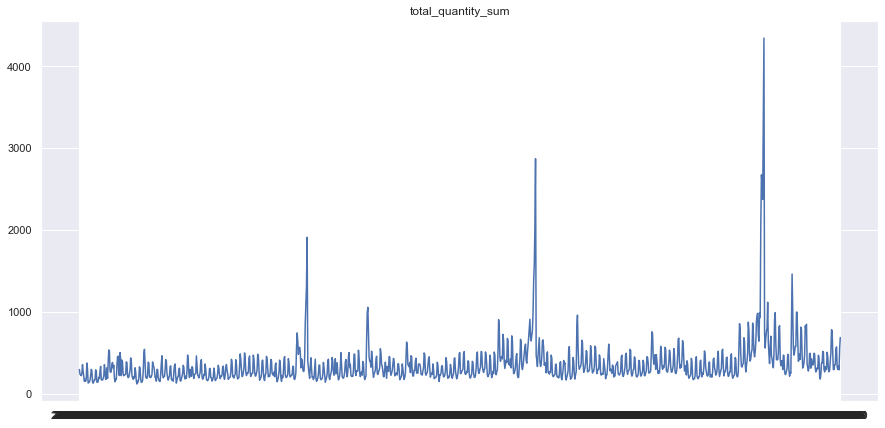

In [266]:
plt.figure(figsize=(15, 7))
plt.plot(data_CSB_267_train.total_quantity_sum)
plt.title('total_quantity_sum')
plt.grid(True)
plt.show()

In [267]:
data_CSB_267_test

CSB          ds  businessId  lagerId_count  lagerId_with_discount_count  \
9411  267  2020-05-01           1             83                            6   
9412  267  2020-05-02           1             83                            6   
9413  267  2020-05-03           1             83                            6   
9414  267  2020-05-04           1             83                            6   
9415  267  2020-05-05           1             83                            6   
...   ...         ...         ...            ...                          ...   
9771  267  2021-04-26           1             83                           15   
9772  267  2021-04-27           1             83                           15   
9773  267  2021-04-28           1             83                           15   
9774  267  2021-04-29           1             83                           15   
9775  267  2021-04-30           1             83                           15   

      discount_min  discount_max  discount_mean  discount_median  \
9411         0.000         0.325          0.020            0.000   
9412         0.000         0.325          0.020            0.000   
9413         0.000         0.325          0.020            0.000   
9414         0.000         0.325          0.020            0.000   
9415         0.000         0.325          0.020            0.000   
...            ...           ...            ...              ...   
9771         0.000         0.329          0.042            0.000   
9772         0.000         0.329          0.042            0.000   
9773         0.000         0.329          0.042            0.000   
9774         0.000         0.329          0.042            0.000   
9775         0.000         0.329          0.042            0.000   

      discount_std  filialArea_baseline_min  filialArea_baseline_max  \
9411         0.072                    0.000              379,697.000   
9412         0.072                    0.000              378,222.000   
9413         0.072                    0.000              379,697.000   
9414         0.072                    0.000              379,697.000   
9415         0.072                    0.000              379,697.000   
...            ...                      ...                      ...   
9771         0.095                    0.000              426,882.000   
9772         0.095                    0.000              426,882.000   
9773         0.095                    0.000              426,882.000   
9774         0.095                    0.000              426,882.000   
9775         0.095                    0.000              426,882.000   

      filialArea_baseline_mean  filialArea_baseline_median  \
9411                79,073.892                   3,695.000   
9412                79,009.337                   3,695.000   
9413                78,932.687                   3,695.000   
9414                79,016.916                   3,695.000   
9415                79,022.024                   3,695.000   
...                        ...                         ...   
9771                72,382.133                  28,615.000   
9772                72,382.133                  28,615.000   
9773                72,439.229                  28,615.000   
9774                72,848.277                  28,615.000   
9775                72,801.747                  28,615.000   

      filialArea_baseline_std  filialArea_activity_min  \
9411              122,723.891                    0.000   
9412              122,604.216                    0.000   
9413              122,473.000                    0.000   
9414              122,667.581                    0.000   
9415              122,679.924                    0.000   
...                       ...                      ...   
9771              113,287.083                    0.000   
9772              113,287.083                    0.000   
9773              113,408.207                    0.000   
9774              113,718.

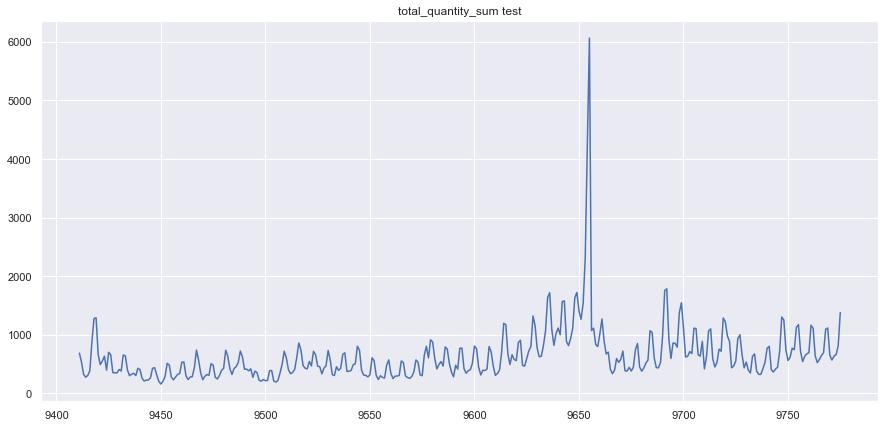

In [268]:
plt.figure(figsize=(15, 7))
plt.plot(data_CSB_267_test.total_quantity_sum)
plt.title('total_quantity_sum test')
plt.grid(True)
plt.show()

In [293]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [298]:
from sklearn.ensemble import RandomForestRegressor

In [288]:
model_regression = LinearRegression()

In [289]:
model_regression2 = Lasso()

In [294]:
model_regression3 = Ridge()

In [271]:
X_train = data_CSB_267_train.drop(['total_quantity_sum', 'CSB', 'ds', 'businessId'], axis=1)

In [272]:
X_test = data_CSB_267_test.drop(['total_quantity_sum', 'CSB', 'ds', 'businessId'], axis=1)

In [273]:
X_train

lagerId_count  lagerId_with_discount_count  discount_min  \
2017-01-01             83                            4         0.000   
2017-01-02             83                            4         0.000   
2017-01-03             83                            4         0.000   
2017-01-04             83                            4         0.000   
2017-01-05             83                            0         0.000   
...                   ...                          ...           ...   
2020-04-27             83                            4         0.000   
2020-04-28             83                            4         0.000   
2020-04-29             83                            1         0.000   
2020-04-30             83                            6         0.000   
2020-05-01             83                            6         0.000   

            discount_max  discount_mean  discount_median  discount_std  \
2017-01-01         0.261          0.009            0.000         0.043   
2017-01-02         0.261          0.009            0.000         0.043   
2017-01-03         0.261          0.009            0.000         0.043   
2017-01-04         0.261          0.009            0.000         0.043   
2017-01-05         0.000          0.000            0.000         0.000   
...                  ...            ...              ...           ...   
2020-04-27         0.328          0.014            0.000         0.062   
2020-04-28         0.328          0.014            0.000         0.062   
2020-04-29         0.214          0.003            0.000         0.024   
2020-04-30         0.325          0.020            0.000         0.072   
2020-05-01         0.325          0.020            0.000         0.072   

            filialArea_baseline_min  filialArea_baseline_max  \
2017-01-01                    0.000              330,801.000   
2017-01-02                    0.000              330,192.000   
2017-01-03                    0.000              330,563.000   
2017-01-04                    0.000              330,649.000   
2017-01-05                    0.000              331,316.000   
...                             ...                      ...   
2020-04-27                    0.000              379,697.000   
2020-04-28                    0.000              379,697.000   
2020-04-29                    0.000              379,697.000   
2020-04-30                    0.000              379,697.000   
2020-05-01                    0.000              379,697.000   

            filialArea_baseline_mean  filialArea_baseline_median  \
2017-01-01                47,778.205                       0.000   
2017-01-02                47,795.566                       0.000   
2017-01-03                47,924.024                       0.000   
2017-01-04                48,153.446                       0.000   
2017-01-05                55,952.012                       0.000   
...                              ...                         ...   
2020-04-27                79,041.988                   3,695.000   
2020-04-28                79,121.120                   3,695.000   
2020-04-29                88,314.434                   3,695.000   
2020-04-30                79,225.747                   3,695.000   
2020-05-01                79,073.892                   3,695.000   

            filialArea_baseline_std  filialArea_activity_min  \
2017-01-01               98,152.304                    0.000   
2017-01-02               98,152.614                    0.000   
2017-01-03               98,381.786                    0.000   
2017-01-04               98,802.870                    0.000   
2017-01-05              107,249.653                    0.000   
...                             ...                      ...   
2020-04-27              119,400.370                    0.000   
2020-04-28              119,581.829                    0.000   
2020-04-29              124,440.839                    0.000   
2020-04-30              123,028.

In [274]:
X_test

lagerId_count  lagerId_with_discount_count  discount_min  discount_max  \
9411             83                            6         0.000         0.325   
9412             83                            6         0.000         0.325   
9413             83                            6         0.000         0.325   
9414             83                            6         0.000         0.325   
9415             83                            6         0.000         0.325   
...             ...                          ...           ...           ...   
9771             83                           15         0.000         0.329   
9772             83                           15         0.000         0.329   
9773             83                           15         0.000         0.329   
9774             83                           15         0.000         0.329   
9775             83                           15         0.000         0.329   

      discount_mean  discount_median  discount_std  filialArea_baseline_min  \
9411          0.020            0.000         0.072                    0.000   
9412          0.020            0.000         0.072                    0.000   
9413          0.020            0.000         0.072                    0.000   
9414          0.020            0.000         0.072                    0.000   
9415          0.020            0.000         0.072                    0.000   
...             ...              ...           ...                      ...   
9771          0.042            0.000         0.095                    0.000   
9772          0.042            0.000         0.095                    0.000   
9773          0.042            0.000         0.095                    0.000   
9774          0.042            0.000         0.095                    0.000   
9775          0.042            0.000         0.095                    0.000   

      filialArea_baseline_max  filialArea_baseline_mean  \
9411              379,697.000                79,073.892   
9412              378,222.000                79,009.337   
9413              379,697.000                78,932.687   
9414              379,697.000                79,016.916   
9415              379,697.000                79,022.024   
...                       ...                       ...   
9771              426,882.000                72,382.133   
9772              426,882.000                72,382.133   
9773              426,882.000                72,439.229   
9774              426,882.000                72,848.277   
9775              426,882.000                72,801.747   

      filialArea_baseline_median  filialArea_baseline_std  \
9411                   3,695.000              122,723.891   
9412                   3,695.000              122,604.216   
9413                   3,695.000              122,473.000   
9414                   3,695.000              122,667.581   
9415                   3,695.000              122,679.924   
...                          ...                      ...   
9771                  28,615.000              113,287.083   
9772                  28,615.000              113,287.083   
9773                  28,615.000              113,408.207   
9774                  28,615.000              113,718.490   
9775                  28,615.000              113,681.892   

      filialArea_activity_min  filialArea_activity_max  \
9411                    0.000              293,746.000   
9412                    0.000              291,603.000   
9413                    0.000              277,434.000   
9414                    0.000              269,085.000   
9415                    0.000              252,952.000   
...                       ...                      ...   
9771                    0.000              419,707.000   
9772                    0.000              419,707.000   
9773                    0.000              419,707.000   
9774                    0.000              418,784.000   
9775            

In [275]:
y_train = data_CSB_267_train['total_quantity_sum']

In [276]:
y_train

2017-01-01   298.000
2017-01-02   240.000
2017-01-03   234.000
2017-01-04   224.000
2017-01-05   252.000
               ...  
2020-04-27   300.000
2020-04-28   341.000
2020-04-29   294.000
2020-04-30   560.000
2020-05-01   689.000
Name: total_quantity_sum, Length: 1217, dtype: float64

In [277]:
y_test = data_CSB_267_test['total_quantity_sum']

In [278]:
y_test

9411     689.000
9412     541.000
9413     329.000
9414     278.000
9415     307.000
          ...   
9771     571.000
9772     638.000
9773     663.000
9774     810.000
9775   1,380.000
Name: total_quantity_sum, Length: 365, dtype: float64

In [324]:
model_regression4 = RandomForestRegressor(n_estimators = 100, criterion = "mse", max_depth = 10)

In [315]:
model_regression.fit(X_train, y_train)

LinearRegression()

In [291]:
model_regression2.fit(X_train, y_train)

Lasso()

In [296]:
model_regression3.fit(X_train, y_train)

Ridge()

In [325]:
model_regression4.fit(X_train, y_train)

RandomForestRegressor(max_depth=10)

In [281]:
# y_pred_regr = model_regression.predict(X_train)

In [285]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
#     if plot_intervals:
#         cv = cross_val_score(model, X_train, y_train, 
#                                     cv=tscv, 
#                                     scoring="neg_mean_absolute_error")
#         mae = cv.mean() * (-1)
#         deviation = cv.std()
        
#         scale = 1.96
#         lower = prediction - (mae + scale * deviation)
#         upper = prediction + (mae + scale * deviation)
        
#         plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
#         plt.plot(upper, "r--", alpha=0.5)
        
#         if plot_anomalies:
#             anomalies = np.array([np.NaN]*len(y_test))
#             anomalies[y_test<lower] = y_test[y_test<lower]
#             anomalies[y_test>upper] = y_test[y_test>upper]
#             plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
#     error = mean_absolute_percentage_error(prediction, y_test)
#     plt.title("Mean absolute percentage error {0:.2f}%".format(error))
#     plt.legend(loc="best")
#     plt.tight_layout()
#     plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

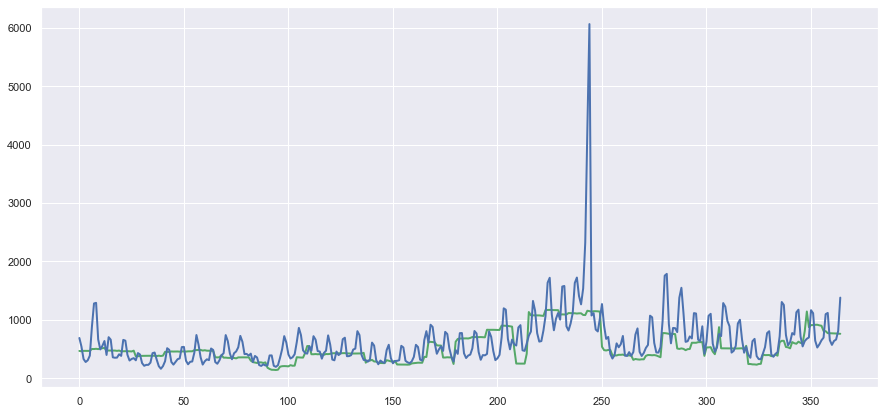

In [286]:
plotModelResults(model_regression, X_train=X_train, X_test=X_test, plot_intervals=True)

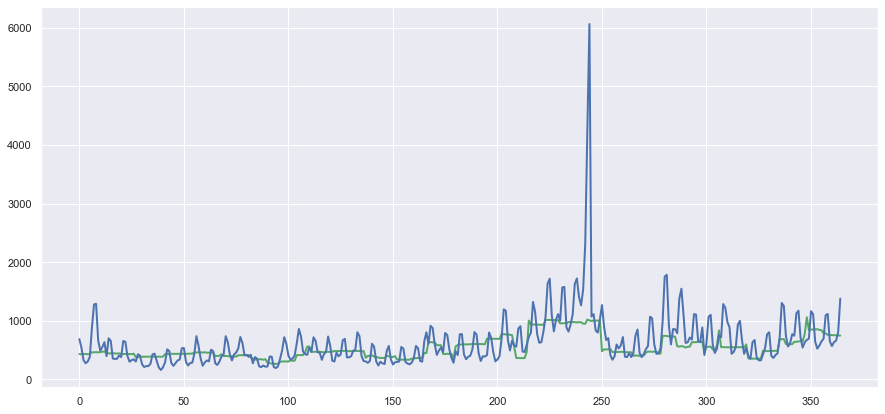

In [292]:
plotModelResults(model_regression2, X_train=X_train, X_test=X_test, plot_intervals=True)

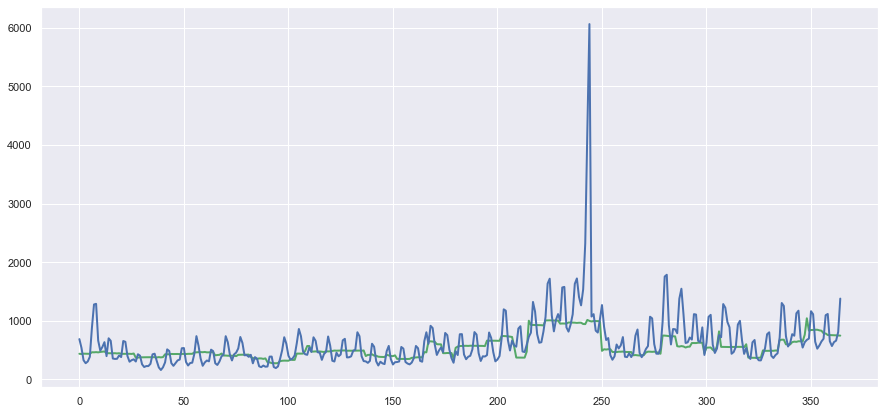

In [297]:
plotModelResults(model_regression3, X_train=X_train, X_test=X_test, plot_intervals=True)

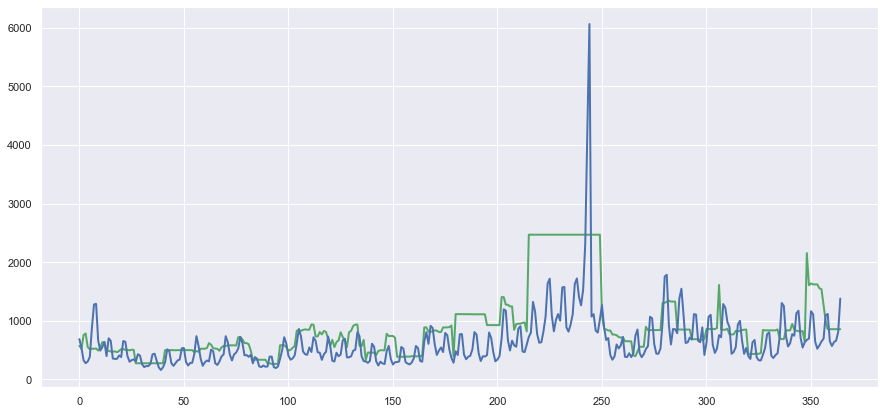

In [326]:
plotModelResults(model_regression4, X_train=X_train, X_test=X_test, plot_intervals=True)

In [333]:
def print_metrics(y_train,y_pred):
    print('Метрики качества на train')
    print('MAE:', mean_absolute_error(y_train, y_pred))
    print('RMSE:', np.sqrt(mean_squared_error(y_train, y_pred)))
    print('R2:',  r2_score(y_train, y_pred))
    print('MAPE:', mean_absolute_percentage_error(y_train, y_pred))
    pass

In [332]:
print_metrics(y_train, model_regression4.predict(X_train))

Метрики качества на train
MAE: 65.26398478778785
RMSE: 92.23588736176708
R2: 0.8840899317078027
MAPE: 19.671551603744106


In [336]:
def print_metrics_test(y_test,y_pred):
    print('Метрики качества на test')
    print('MAE:', mean_absolute_error(y_test, y_pred))
    print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
    print('R2:',  r2_score(y_test, y_pred))
    print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))
    pass

In [337]:
print_metrics_test(y_test, model_regression4.predict(X_test))

Метрики качества на test
MAE: 368.7192238205421
RMSE: 563.1986698487502
R2: -0.39139597974285123
MAPE: 61.18235852659404


## Пишем цикл

In [455]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [369]:
unique_CSB = data['CSB'].unique()
unique_CSB

array([ 267, 1072,  270, 2099, 4118,  476, 2103, 2100, 2619, 2620,  668,
       3986, 2390, 1429,  268, 3985,  260, 2618,  235,  251,  264,  240,
       4125, 2104,  669, 1074, 4110,  670, 4132, 4138], dtype=int64)

In [398]:
result_dict = {}
for csb in unique_CSB[:]:
    #
    train = train_set[train_set['CSB'] == csb]
    test = test_set[test_set['CSB'] == csb]
    
    X_train = train.drop(['total_quantity_sum', 'CSB', 'ds', 'businessId'], axis=1)
    X_test = test.drop(['total_quantity_sum', 'CSB', 'ds', 'businessId'], axis=1)
    
    y_train = train['total_quantity_sum']
    y_test = test['total_quantity_sum']
    
    #model_regression = RandomForestRegressor()
    
    #tune paramethers
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(5, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    
    rf = RandomForestRegressor()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 30, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(X_train, y_train)
    
    #Вставляем лучшие параметры в модель
    model_regression = RandomForestRegressor()
    model_regression.set_params(**rf_random.best_params_)
    
    #Делаем финальный прогон
    model_regression.fit(X_train, y_train)
    
    reg_train_pred = model_regression.predict(X_train)
    reg_test_pred = model_regression.predict(X_test)
    
    result_dict[csb] = reg_test_pred 
    
    
    print(csb, len(reg_train_pred), len(y_train), rf_random.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
267 1217 1217 {'n_estimators': 322, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 57, 'bootstrap': True}
Fitting 3 folds for each of 30 candidates, totalling 90 fits
1072 1217 1217 {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 5, 'bootstrap': True}
Fitting 3 folds for each of 30 candidates, totalling 90 fits
270 1217 1217 {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 47, 'bootstrap': True}
Fitting 3 folds for each of 30 candidates, totalling 90 fits
2099 1217 1217 {'n_estimators': 411, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 110, 'bootstrap': False}
Fitting 3 folds for each of 30 candidates, totalling 90 fits
4118 1217 1217 {'n_estimators': 411, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth'

## Сохраненные лучшие эстиматоры

In [399]:
result_dict

{267: array([ 534.34132175,  522.11264833,  648.23730605,  650.48371143,
         486.01524718,  465.03837273,  513.20789743,  513.28582186,
         512.74951234,  476.95654211,  529.58452224,  596.41558604,
         592.04656431,  470.63553863,  470.63553863,  455.74029812,
         463.52042748,  460.73536122,  460.16060154,  470.2889187 ,
         483.5932214 ,  483.6432214 ,  475.87866831,  477.1507217 ,
         466.52562452,  479.63706864,  476.4297639 ,  277.88976326,
         277.88976326,  277.88976326,  277.88976326,  277.88976326,
         277.88976326,  277.88976326,  277.88976326,  277.88976326,
         277.88976326,  277.88976326,  277.88976326,  277.88976326,
         277.88976326,  487.88260143,  488.72613601,  487.97500468,
         487.72617544,  487.97500468,  483.36848723,  487.72617544,
         487.72617544,  487.72617544,  487.72617544,  484.27153917,
         487.72617544,  487.28154652,  487.72617544,  476.4902529 ,
         477.63989892,  449.63098711,  482.

In [402]:
final_df = pd.DataFrame(result_dict)
final_df

267     1072      270       2099    4118    476     2103    2100  \
0     534.341 145.210 2,027.756 2,274.341 772.068 847.404 478.473 121.395   
1     522.113 145.374 2,032.160 1,690.332 693.040 731.296 470.744 114.414   
2     648.237 145.374 1,979.885 1,676.138 693.402 728.124 455.945 121.476   
3     650.484 145.374 1,892.265 1,692.253 652.791 660.434 456.019 117.491   
4     486.015 145.374 1,979.832 2,238.888 642.558 651.270 465.071 116.880   
..        ...     ...       ...       ...     ...     ...     ...     ...   
360 1,118.833 149.142 1,987.765 1,877.020 988.672 446.436 306.216 150.230   
361 1,118.833 149.142 1,741.411 1,875.558 988.672 436.079 304.303 150.425   
362 1,118.833 149.142 1,988.983 1,881.209 985.499 433.805 308.953 152.167   
363   977.162 149.142 1,918.659 2,353.576 985.499 433.798 491.709 155.515   
364   946.327 149.142 2,052.229 2,336.557 983.257 445.583 470.630 155.515   

       2619    2620    668    3986    2390   1429    268    3985    260   \
0   148.173  79.585 223.542 29.575 385.371 32.979 266.290 97.482 259.520   
1   126.168  79.585 199.024 29.043 360.255 31.040 241.405 97.482 252.824   
2   125.840  79.585 197.365 29.623 362.945 32.979 252.059 90.987 220.103   
3   117.522  78.539 213.090 35.738 296.448 32.979 248.410 91.192 227.936   
4   118.152  78.539 213.090 35.738 298.367 32.979 237.020 91.192 223.661   
..      ...     ...     ...    ...     ...    ...     ...    ...     ...   
360 222.462 195.959 674.392 46.307 472.536 44.806 261.147 39.392 633.315   
361 235.082 194.416 651.305 46.307 472.536 44.806 261.147 41.722 633.315   
362 226.164 194.071 636.096 46.262 472.536 44.806 261.147 41.722 633.281   
363 226.711 195.883 670.556 46.271 472.972 44.831 201.357 41.722 700.845   
364 226.961 195.883 675.325 46.810 436.371 44.831 200.375 41.722 700.845   

      2618      235       251     264     240     4125    2104    669   \
0   21.140 4,386.833 1,102.352 266.091 104.000 769.405  91.081 582.784   
1   21.059 4,269.136 1,089.594 239.443 104.000 647.538  89.474 336.928   
2   21.363 4,228.348 1,088.290 238.436 125.667 643.414  88.691 321.834   
3   21.064 4,108.946   422.178 197.079 125.667 335.493  57.218 293.564   
4   21.064 4,037.382   419.333 197.079 125.667 335.493  57.094 495.122   
..     ...       ...       ...     ...     ...     ...     ...     ...   
360 43.782 3,727.143   799.299 345.681 385.015 602.905  98.597 775.458   
361 43.766 3,657.367   799.230 345.681 385.015 593.697 106.316 793.898   
362 44.468 3,671.165   799.299 345.681 385.015 593.697 106.316 775.458   
363 44.454 3,864.941   800.383 345.681 385.015 597.336 106.316 787.358   
364 45.616 3,864.941   800.331 345.681 385.015 598.922 106.316 790.530   

       1074      4110      670       4132    4138  
0   209.042   424.592   825.723   128.456 458.443  
1   210.493   425.384   725.117   126.477 366.375  
2   216.189   402.285   764.199   125.451 446.469  
3   171.093   402.285   564.052   111.988 445.853  
4   173.504   424.750   564.052   112.720 445.853  
..      ...       ...       ...       ...     ...  
360 976.607 1,911.816 2,920.431 1,089.991 639.939  
361 979.132 2,018.403 2,925.183 1,089.991 639.939  
362 979.132 2,018.403 2,935.149 1,089.991 639.939  
363 986.047 1,907.984 2,745.903 1,016.622 642.299  
364 986.047 2,213.636 2,679.621 1,016.622 609.284  

[365 rows x 30 columns]

In [445]:
final_df.to_csv("rf_prediction_table.csv")

In [437]:
def plotModelResults1(prediction, y_test, plot_intervals=False, plot_anomalies=False, x=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    x = x
    prediction = prediction
    label = 'bbb'
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, label="pediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    plt.title(f'{x}')

## Строим графики

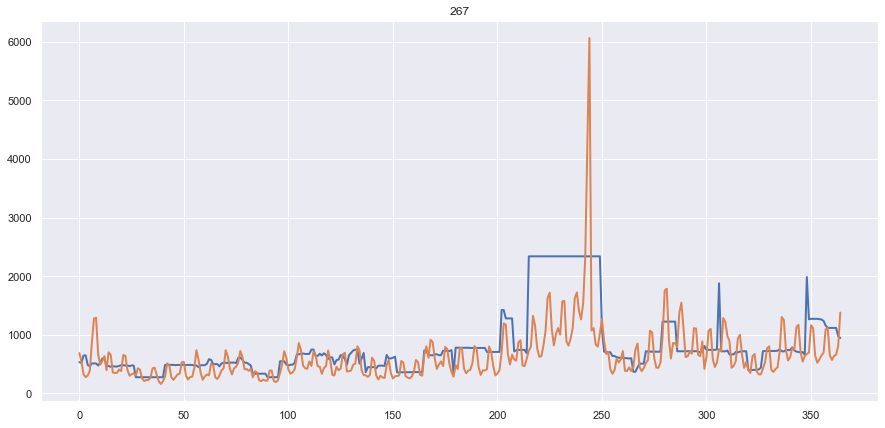

In [439]:
x = 267
plotModelResults1(final_df[x], y_test=test_set[test_set['CSB'] == x]['total_quantity_sum'], plot_intervals=True, x = x)

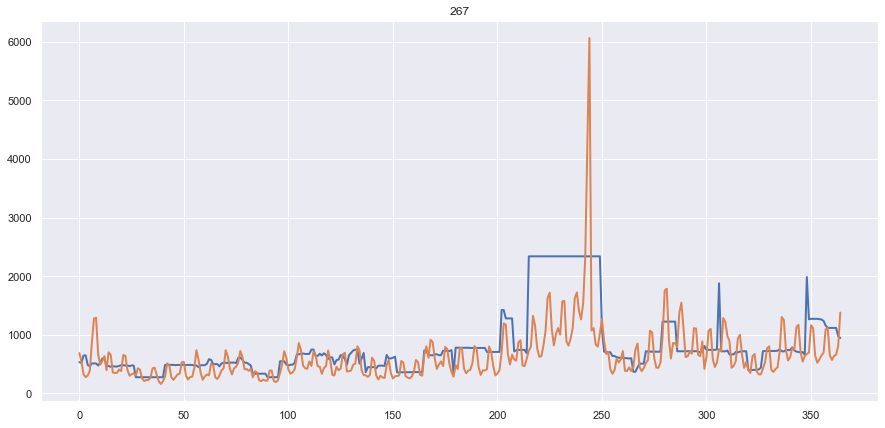

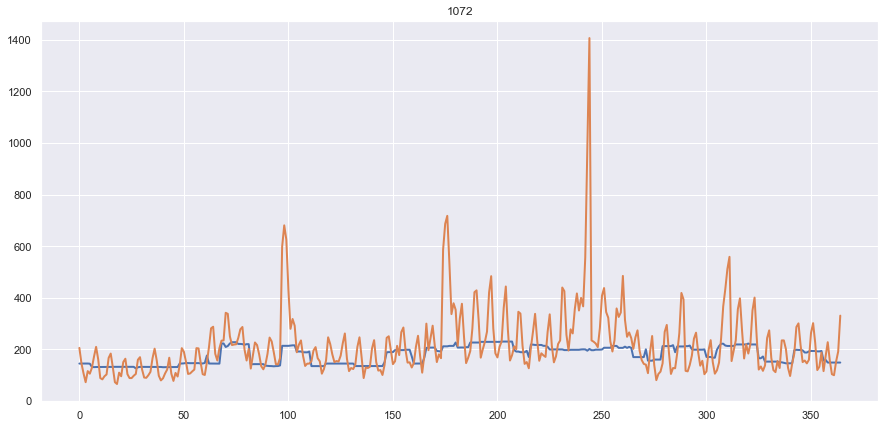

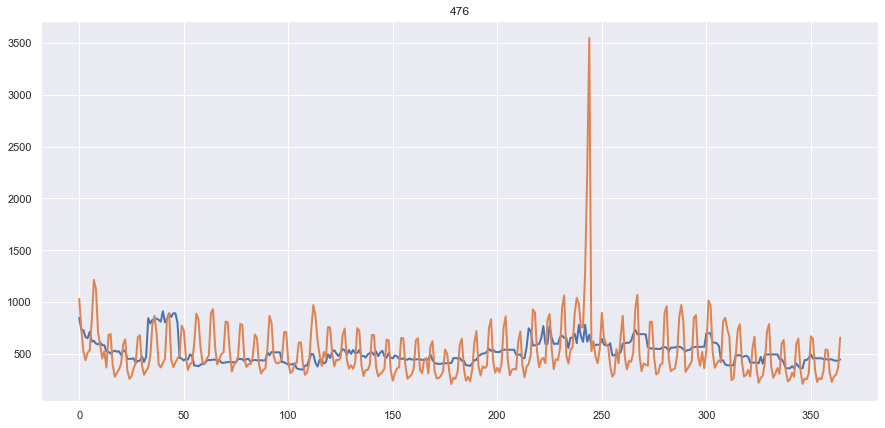

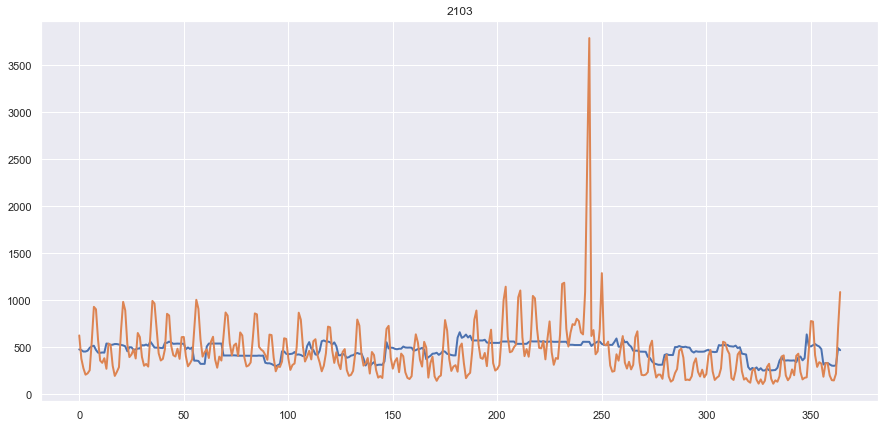

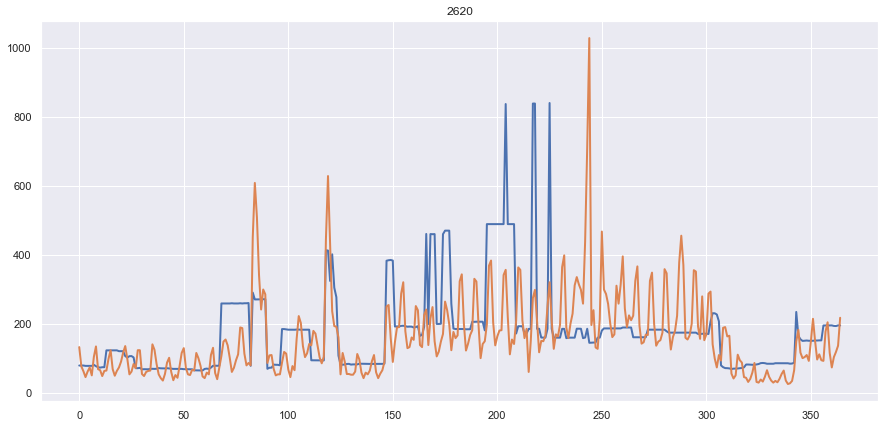

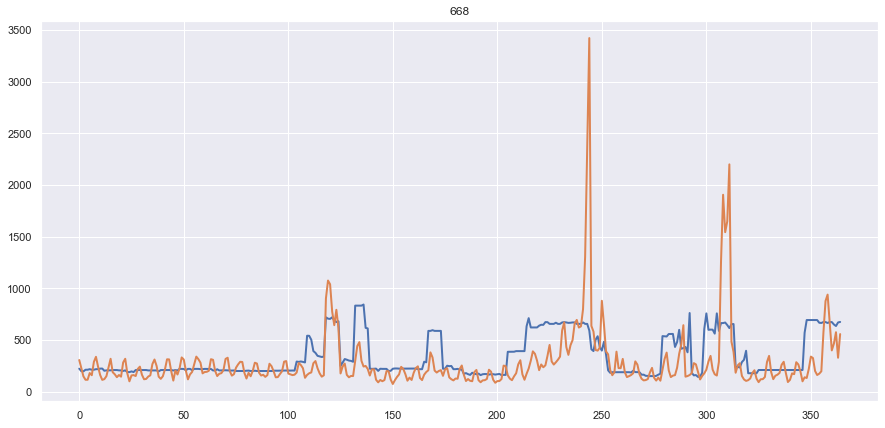

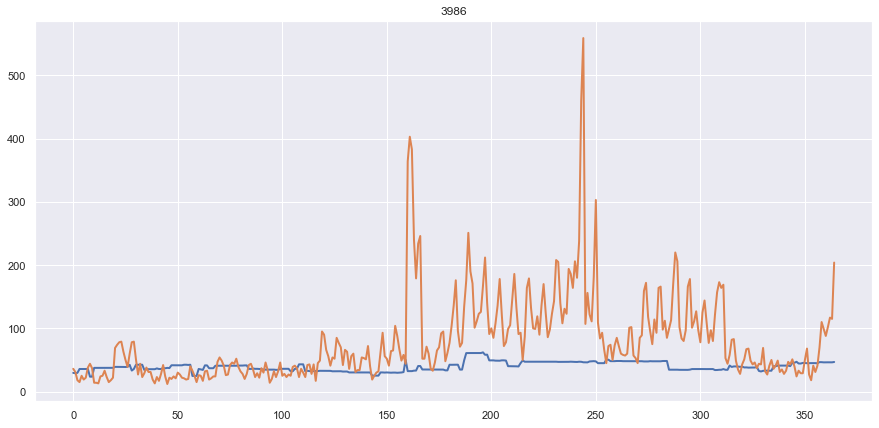

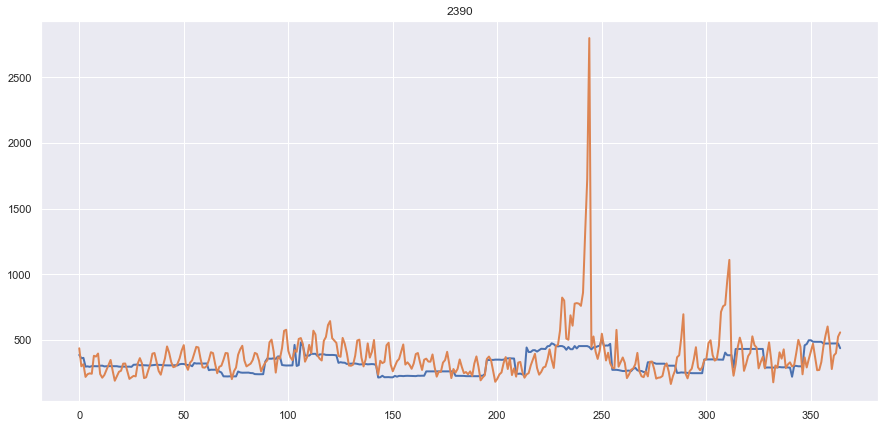

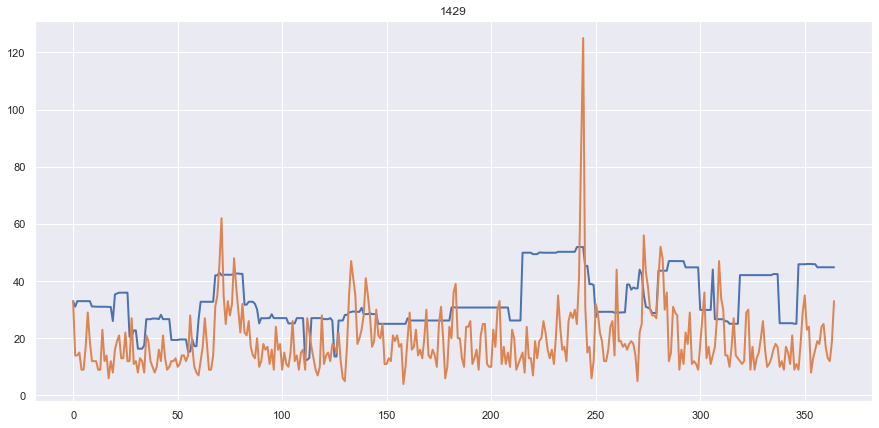

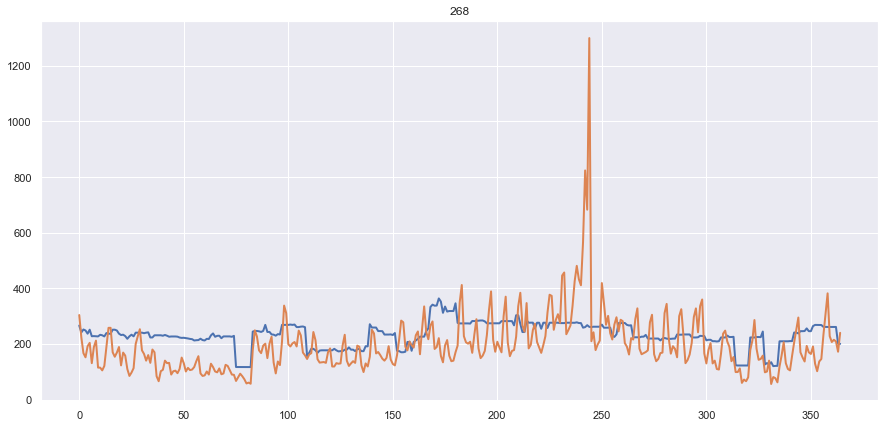

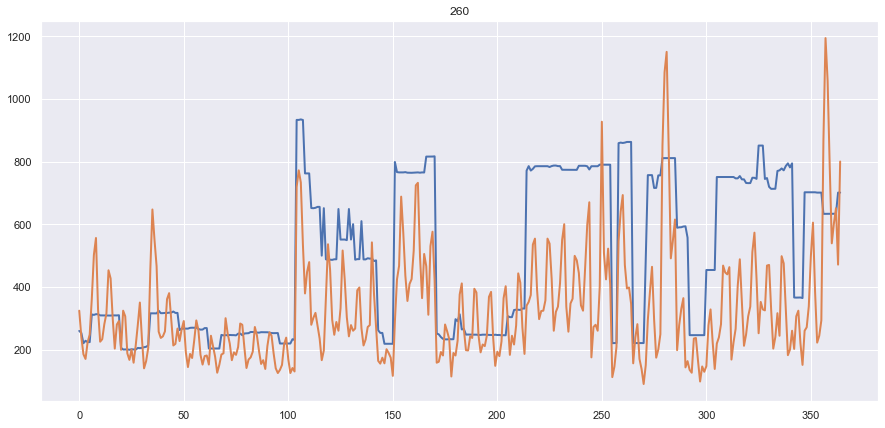

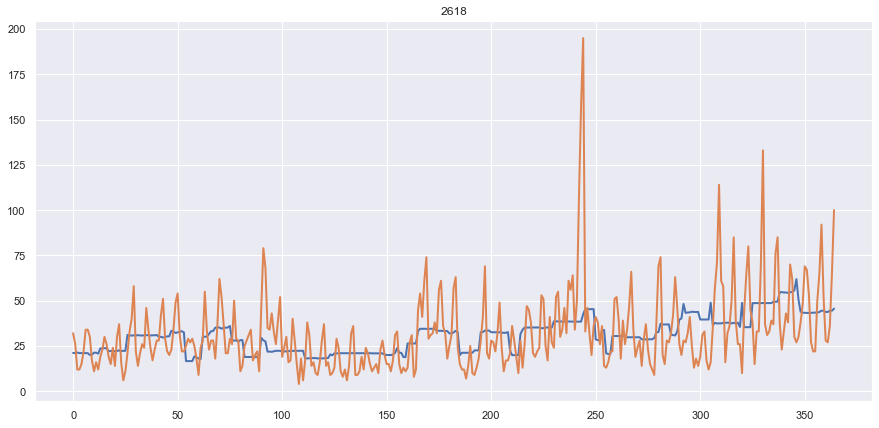

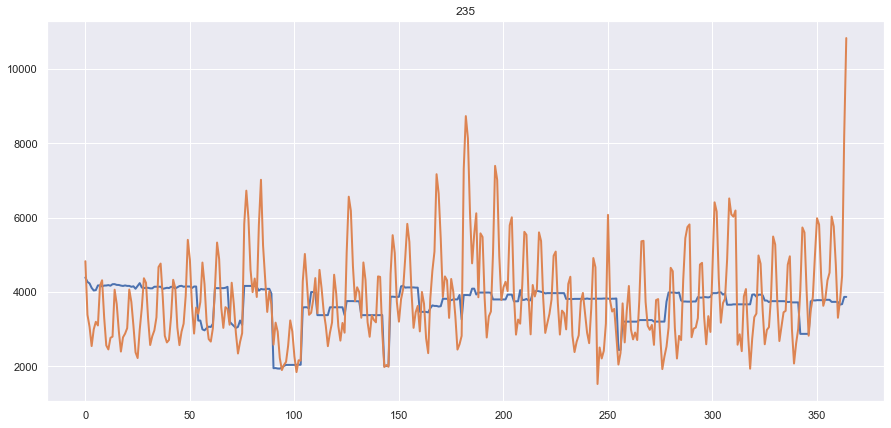

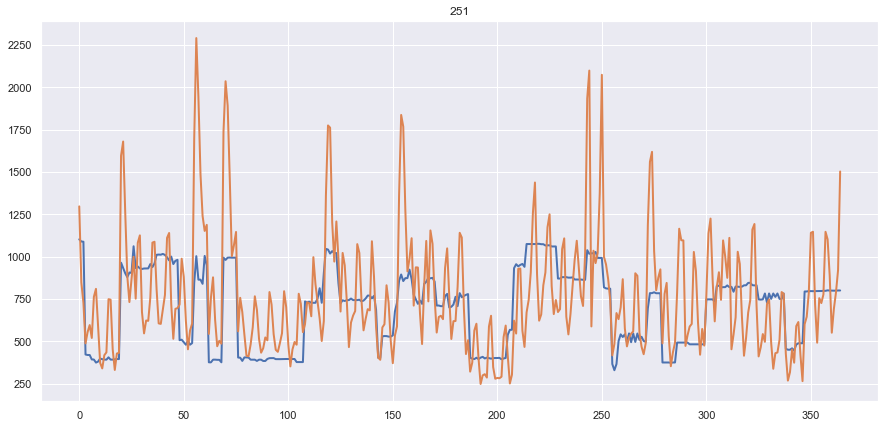

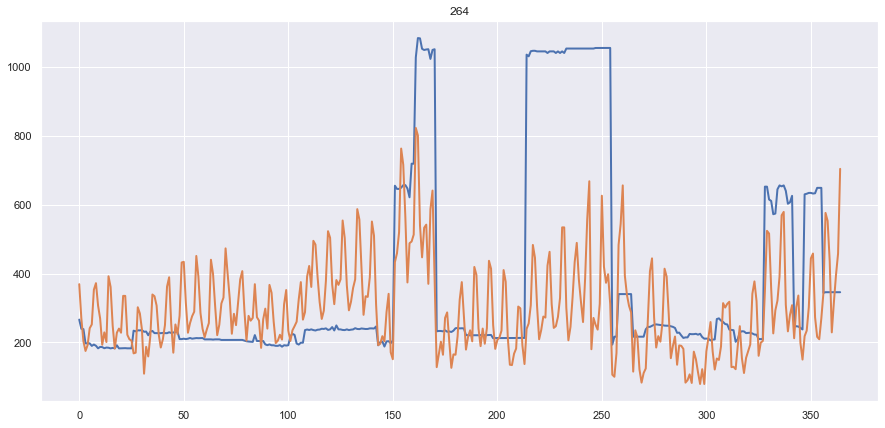

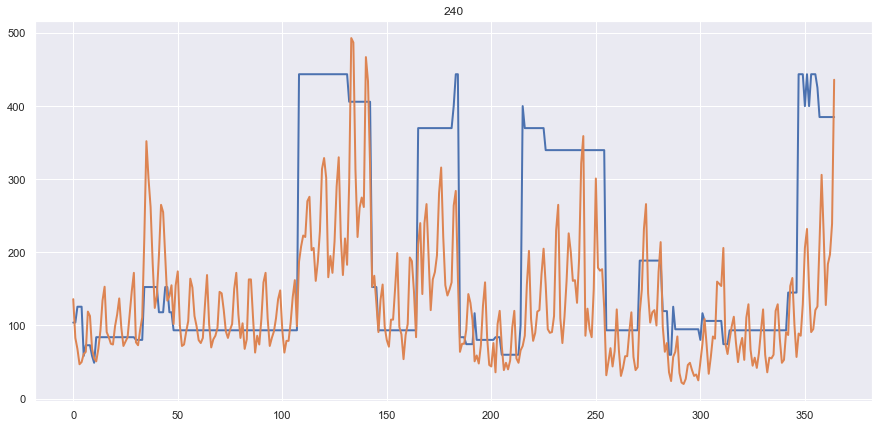

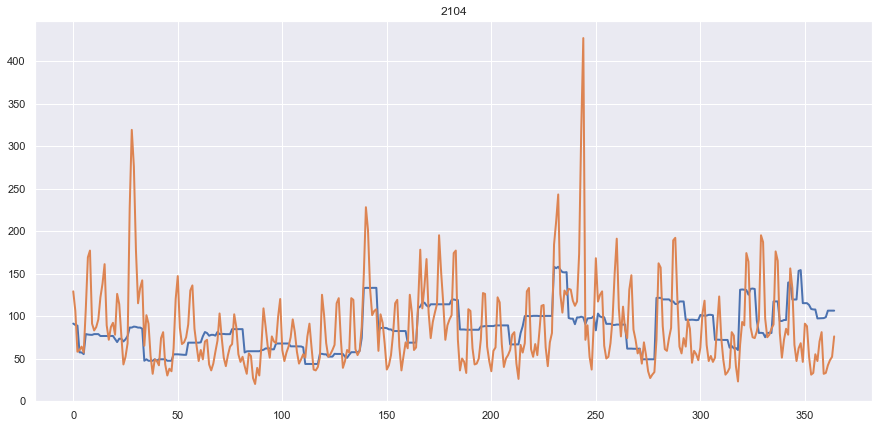

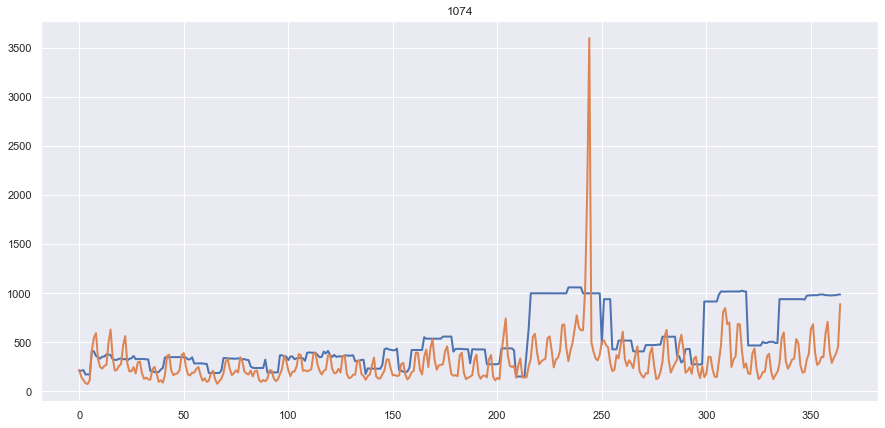

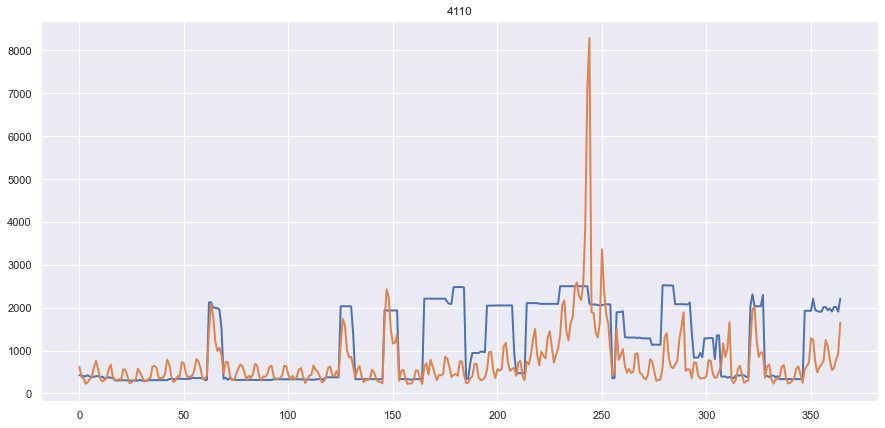

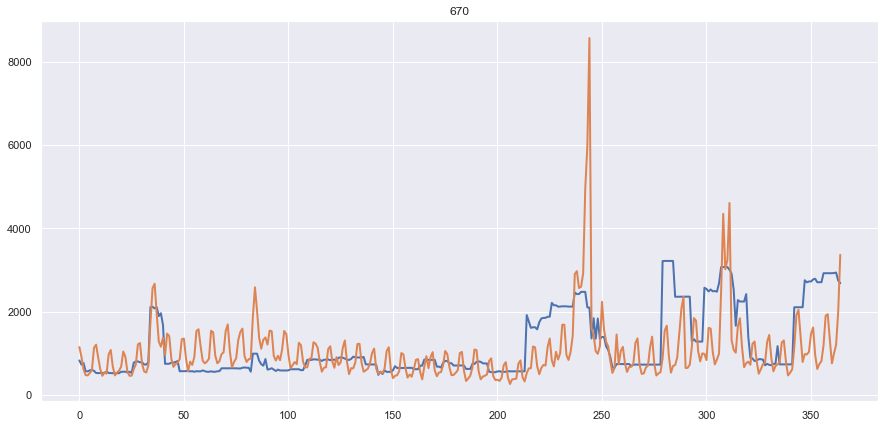

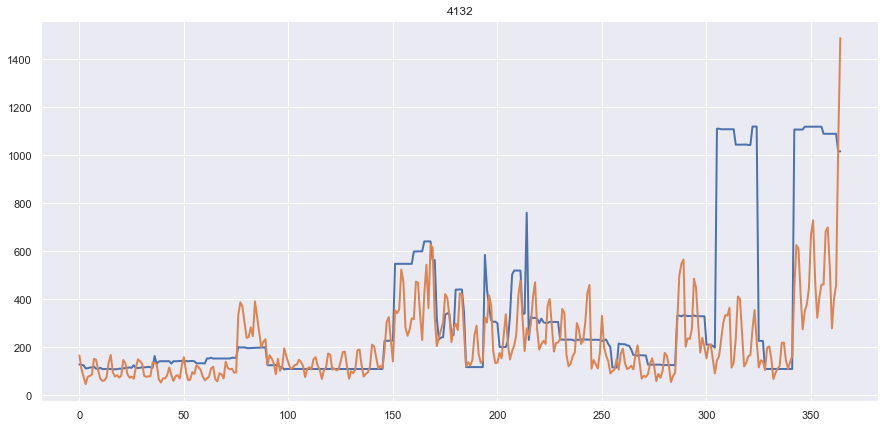

In [440]:
l = list(unique_CSB)
for x in l:
    plotModelResults1(final_df[x], y_test=test_set[test_set['CSB'] == x]['total_quantity_sum'], plot_intervals=True, x = x)

## Linear Regression

In [458]:
from sklearn.model_selection import RepeatedKFold

In [466]:
result_dict_lr = {}
for csb in unique_CSB[:]:
    #
    train = train_set[train_set['CSB'] == csb]
    test = test_set[test_set['CSB'] == csb]
    
    X_train = train.drop(['total_quantity_sum', 'CSB', 'ds', 'businessId'], axis=1)
    X_test = test.drop(['total_quantity_sum', 'CSB', 'ds', 'businessId'], axis=1)
    
    y_train = train['total_quantity_sum']
    y_test = test['total_quantity_sum']
    
    model_regression = Ridge()
    
    
#     #tune paramethers
#     # Number of trees in random forest
#     n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 10)]
#     # Number of features to consider at every split
#     max_features = ['auto', 'sqrt']
#     # Maximum number of levels in tree
#     max_depth = [int(x) for x in np.linspace(5, 110, num = 11)]
#     max_depth.append(None)
#     # Minimum number of samples required to split a node
#     min_samples_split = [2, 5, 10]
#     # Minimum number of samples required at each leaf node
#     min_samples_leaf = [1, 2, 4]
#     # Method of selecting samples for training each tree
#     bootstrap = [True, False]
#     # Create the random grid
#     random_grid = {'n_estimators': n_estimators,
#                    'max_features': max_features,
#                    'max_depth': max_depth,
#                    'min_samples_split': min_samples_split,
#                    'min_samples_leaf': min_samples_leaf,
#                    'bootstrap': bootstrap}
    
#     rf = RandomForestRegressor()
#     # Random search of parameters, using 3 fold cross validation, 
#     # search across 100 different combinations, and use all available cores
#     rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 30, cv = 3, verbose=2, random_state=42, n_jobs = -1)
#     # Fit the random search model
#     rf_random.fit(X_train, y_train)
    
#     #Вставляем лучшие параметры в модель
#     model_regression = RandomForestRegressor()
#     model_regression.set_params(**rf_random.best_params_)
    
    #Делаем финальный прогон
    model_regression.fit(X_train, y_train)
    
    reg_train_pred = model_regression.predict(X_train)
    reg_test_pred = model_regression.predict(X_test)
    
    result_dict_lr[csb] = reg_test_pred 
    
    
    print(csb, len(reg_train_pred), len(y_train), rf_random.best_params_)

267 1217 1217 {'n_estimators': 411, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 110, 'bootstrap': False}
1072 1217 1217 {'n_estimators': 411, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 110, 'bootstrap': False}
270 1217 1217 {'n_estimators': 411, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 110, 'bootstrap': False}
2099 1217 1217 {'n_estimators': 411, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 110, 'bootstrap': False}
4118 1217 1217 {'n_estimators': 411, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 110, 'bootstrap': False}
476 1217 1217 {'n_estimators': 411, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 110, 'bootstrap': False}
2103 1217 1217 {'n_estimators': 411, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 110, '

In [467]:
final_df_lr = pd.DataFrame(result_dict_lr)
final_df_lr

267     1072      270       2099      4118    476     2103    2100  \
0   439.000 156.216 1,645.546 1,310.261   622.975 535.693 392.561 141.510   
1   434.793 157.313 1,638.727 1,290.629   635.899 531.880 391.463 135.644   
2   440.600 154.581 1,636.160 1,280.658   657.528 516.330 390.069 141.327   
3   439.612 153.654 1,635.420 1,289.596   744.413 515.848 391.905 140.660   
4   439.090 154.902 1,638.375 1,301.349   758.938 514.431 392.211 134.789   
..      ...     ...       ...       ...       ...     ...     ...     ...   
360 755.938 189.318 2,265.932 2,003.794 1,243.574 516.316 385.555 131.893   
361 754.813 188.974 2,215.783 1,996.077 1,234.013 518.087 379.661 136.143   
362 753.366 188.962 2,225.872 1,996.078 1,251.836 516.466 375.944 137.561   
363 751.073 190.784 2,371.967 2,218.941 1,252.493 519.074 394.104 142.745   
364 748.737 189.764 2,377.566 2,261.890 1,251.685 516.928 391.186 144.050   

       2619    2620    668    3986    2390   1429    268     3985    260   \
0   117.297  85.187  91.340 37.541 345.802 23.671 200.136  71.865  67.846   
1   115.826  85.189  90.301 37.617 345.246 23.603 198.296  71.738  68.398   
2   116.514  85.189  89.077 37.592 345.161 23.671 194.745  71.036  56.103   
3   115.428  85.224  87.737 29.098 344.537 23.671 195.467  70.753  81.282   
4   115.717  85.143  86.261 29.098 345.439 23.671 195.050  70.129  82.853   
..      ...     ...     ...    ...     ...    ...     ...     ...     ...   
360 302.555 278.508 493.788 76.797 469.689 39.343 161.338 245.175 471.897   
361 307.195 281.430 493.560 76.632 469.930 39.343 158.847 245.269 464.908   
362 305.550 280.432 495.186 76.488 470.046 39.343 157.806 245.294 452.242   
363 309.620 278.639 494.504 76.230 471.700 40.105 190.633 250.042 544.775   
364 308.038 276.912 494.663 77.150 467.924 40.105 190.698 259.562 527.128   

      2618      235       251      264     240     4125    2104    669   \
0   23.999 2,985.294   916.501  182.308  72.580 592.011  60.184 287.823   
1   23.423 2,966.148   962.860  185.494  72.484 563.788  60.243 287.485   
2   23.425 2,955.379   993.514  182.905  72.201 562.562  60.238 285.527   
3   23.213 3,104.197   847.627   43.033  72.467 373.749  47.569 278.905   
4   23.213 3,067.383   856.807   43.033  71.982 381.652  47.237 284.886   
..     ...       ...       ...      ...     ...     ...     ...     ...   
360 48.212 4,036.706   966.312  -62.966 249.172 389.084 128.510 753.463   
361 48.148 4,035.547   973.528  -74.858 249.172 364.995 130.194 752.499   
362 48.092 4,050.511   971.572  -76.601 247.398 395.549 130.571 748.489   
363 47.863 4,195.476   996.335  -86.328 247.038 393.701 130.221 711.112   
364 47.521 4,198.192 1,026.937 -106.688 246.846 411.386 129.677 696.221   

         1074      4110      670     4132      4138  
0     251.852   229.080   817.233  72.014   236.694  
1     252.362   229.738   809.713  69.930   235.019  
2     253.969   228.744   817.105  63.385   234.612  
3     205.002   228.744   478.672 -37.107   233.851  
4     202.494   229.089   480.195 -36.699   234.189  
..        ...       ...       ...     ...       ...  
360 1,202.149 1,198.871 3,171.150 539.052 1,112.310  
361 1,201.797 1,186.142 3,165.914 538.703 1,109.535  
362 1,199.899 1,215.225 3,202.844 535.851 1,107.118  
363 1,202.660 1,220.717 3,498.119 553.064 1,095.389  
364 1,204.980 1,198.053 3,599.649 525.702 1,049.322  

[365 rows x 30 columns]

In [468]:
# final_df_lr.to_csv("lr_prediction_table.csv")

## Строим графики Ridge Regression

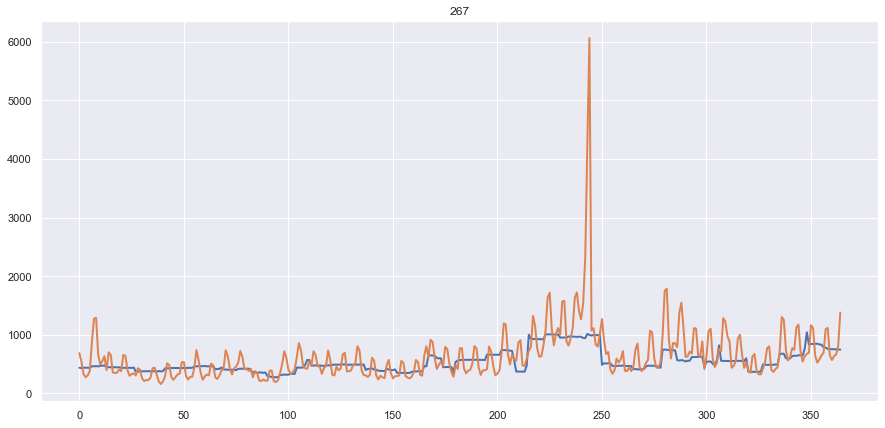

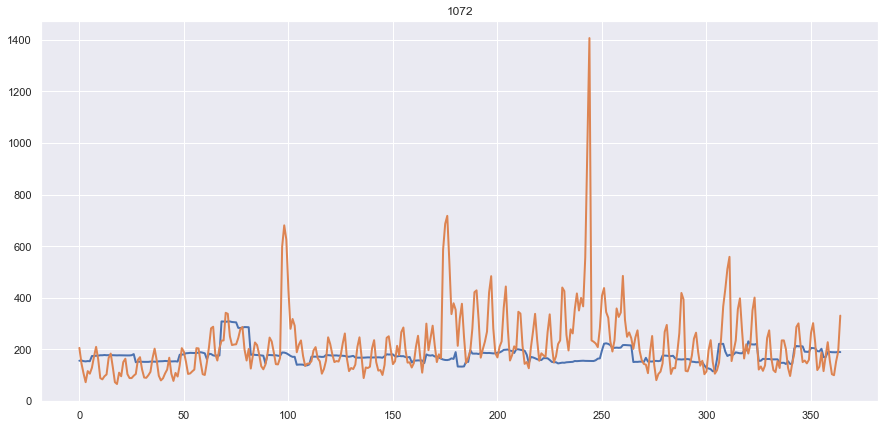

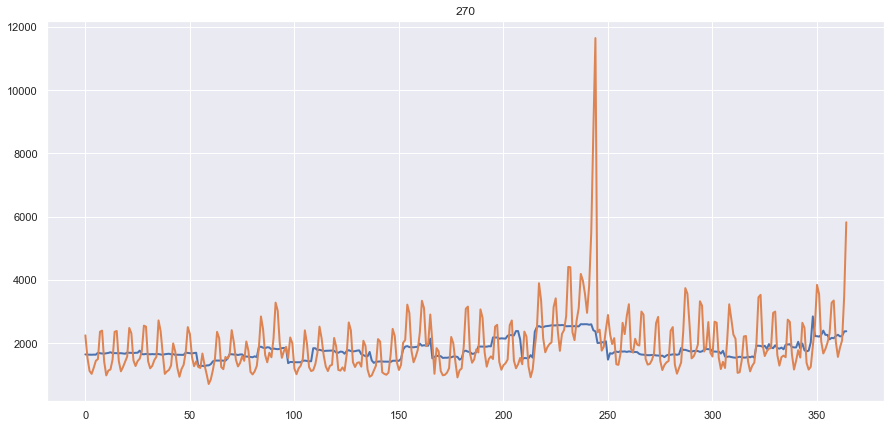

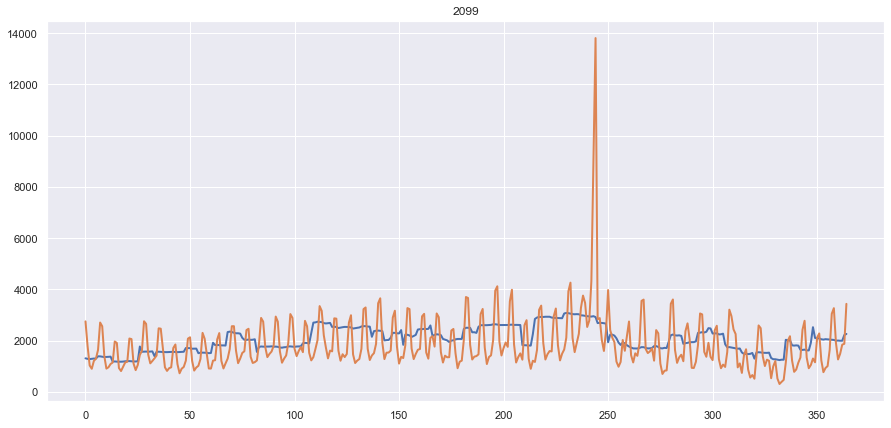

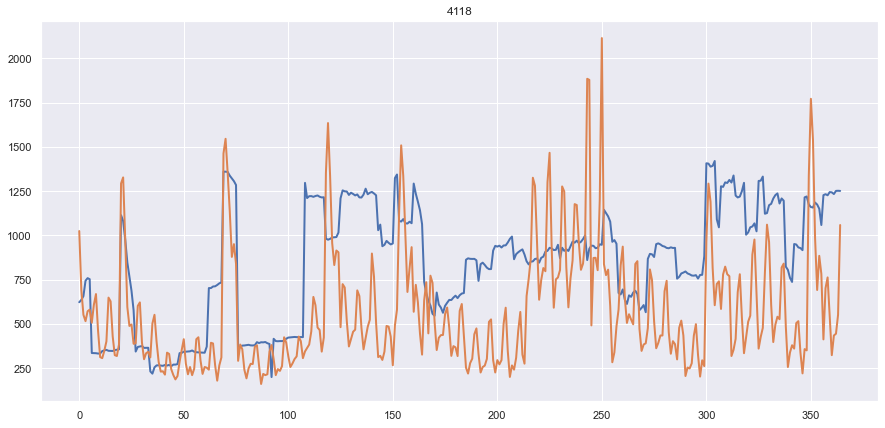

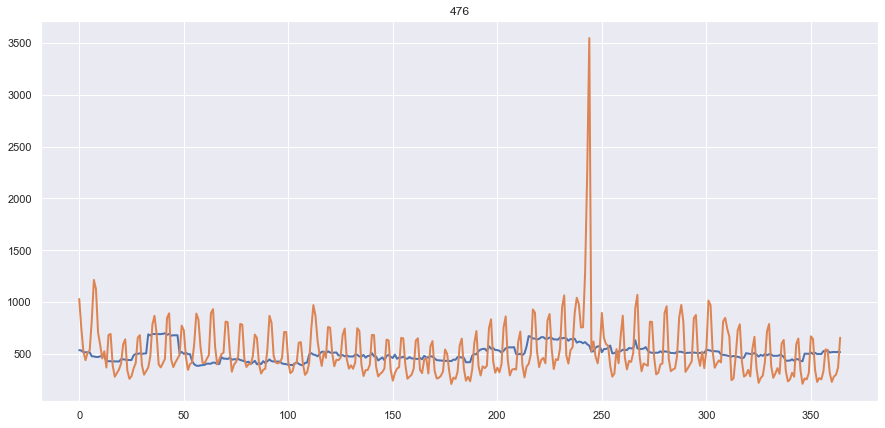

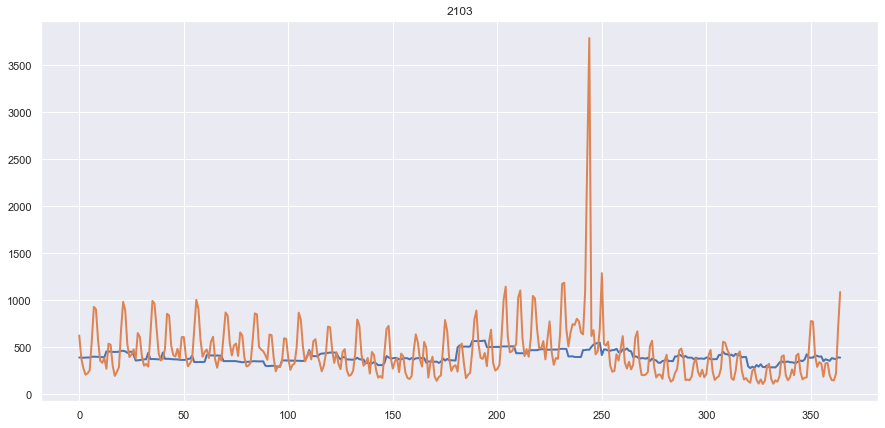

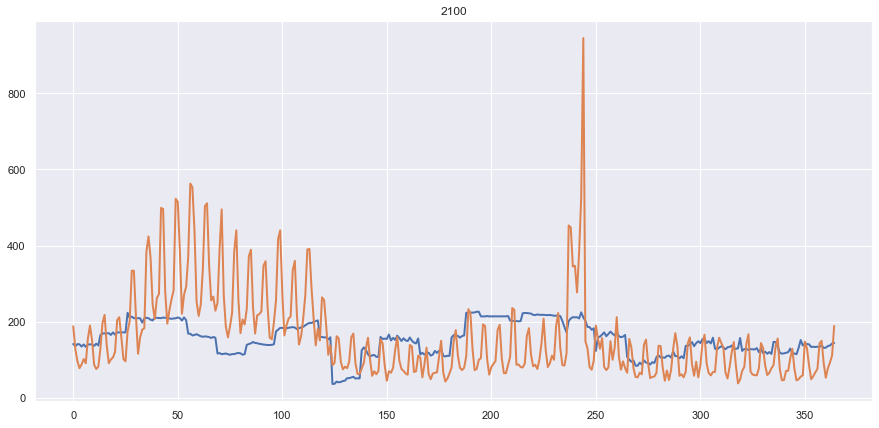

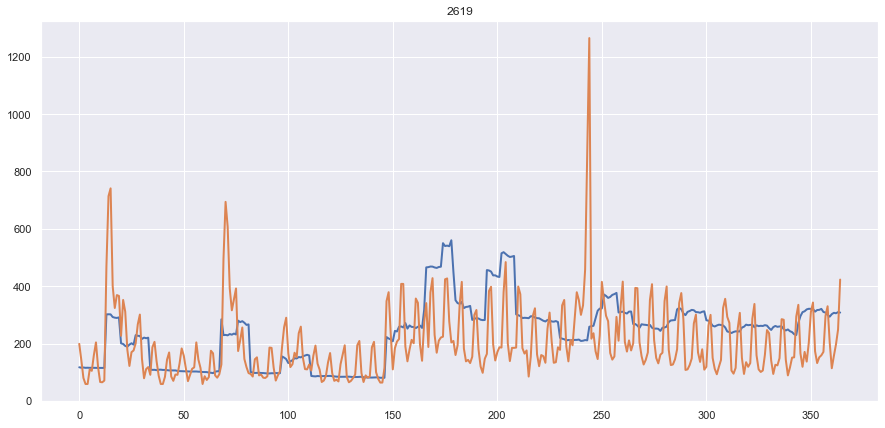

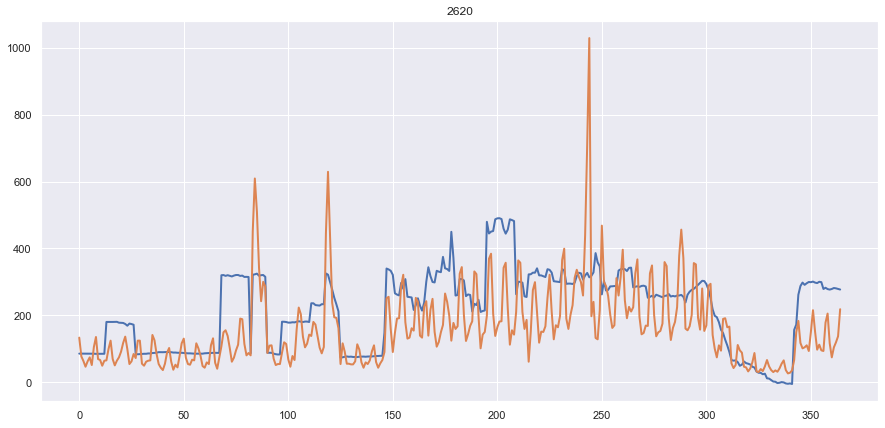

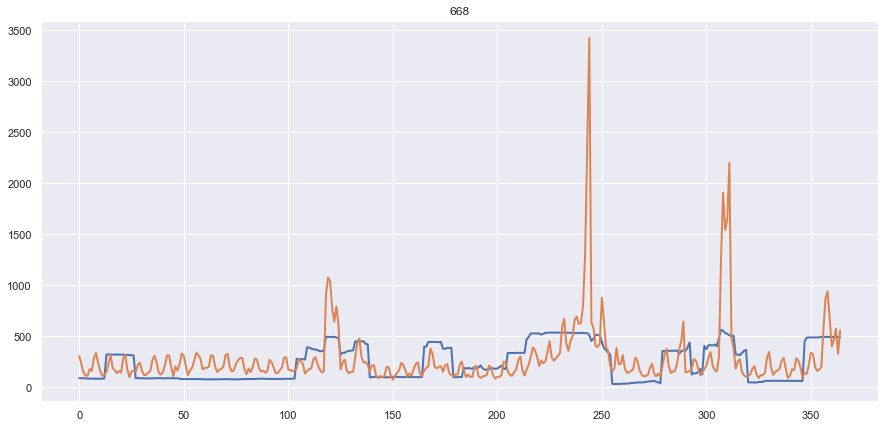

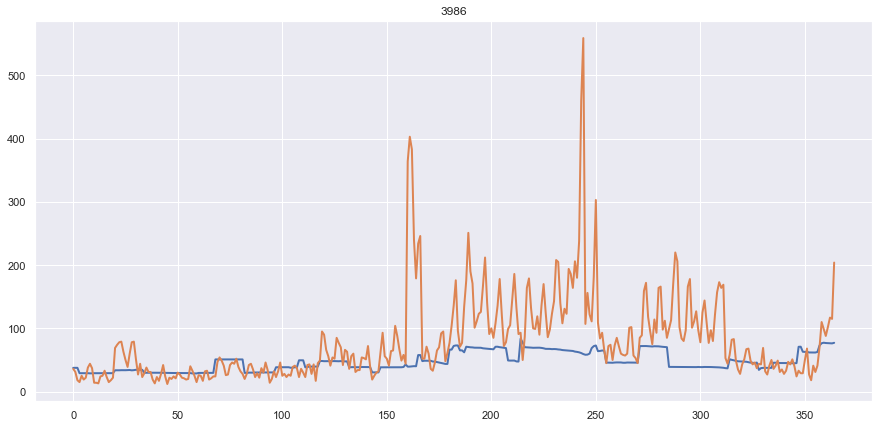

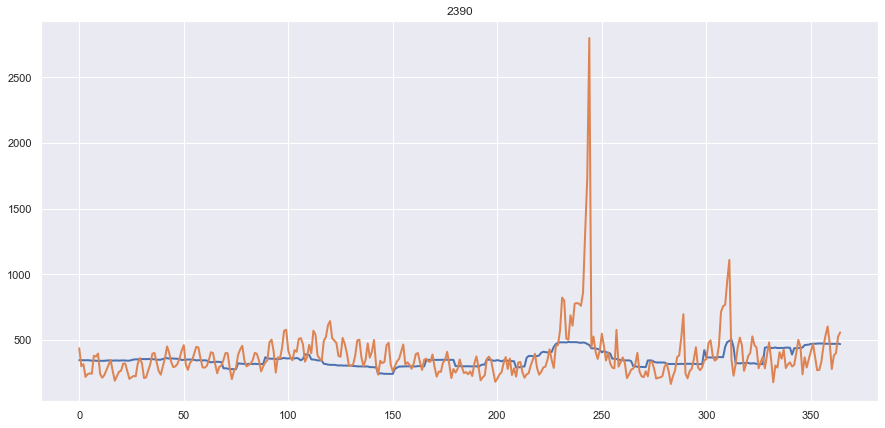

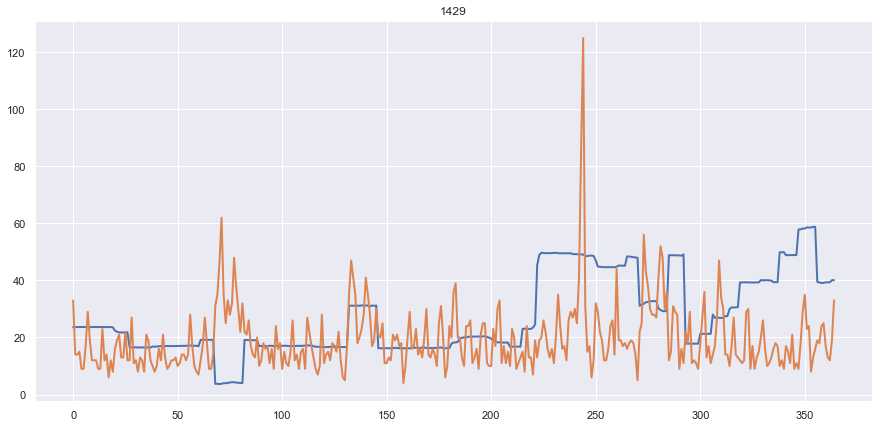

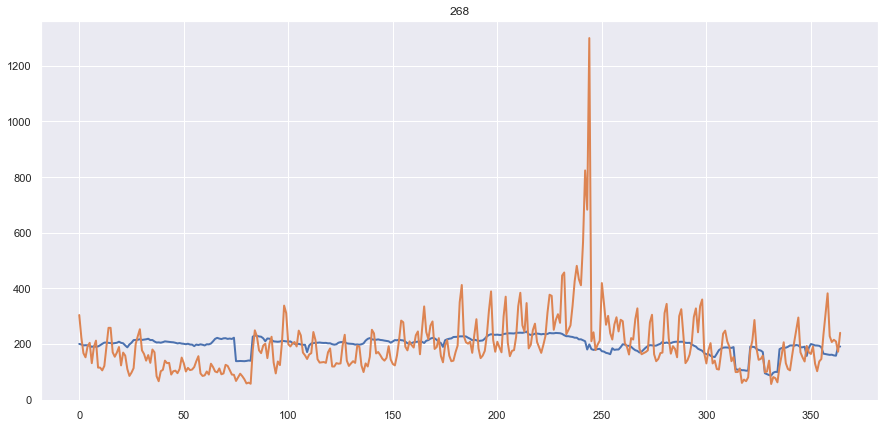

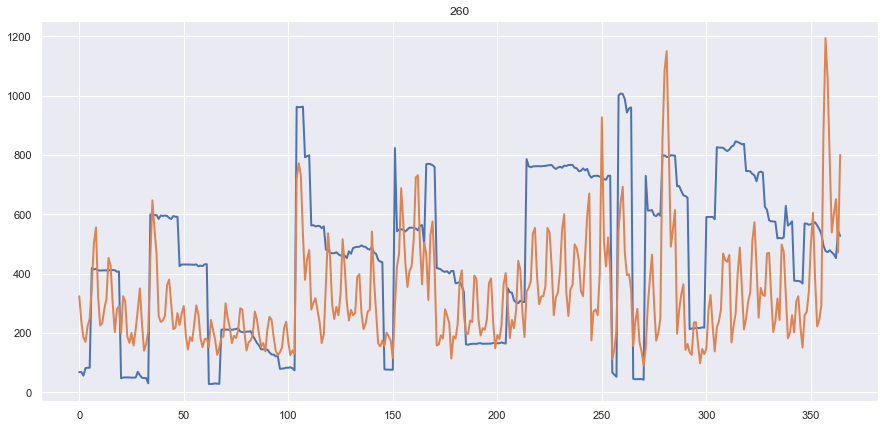

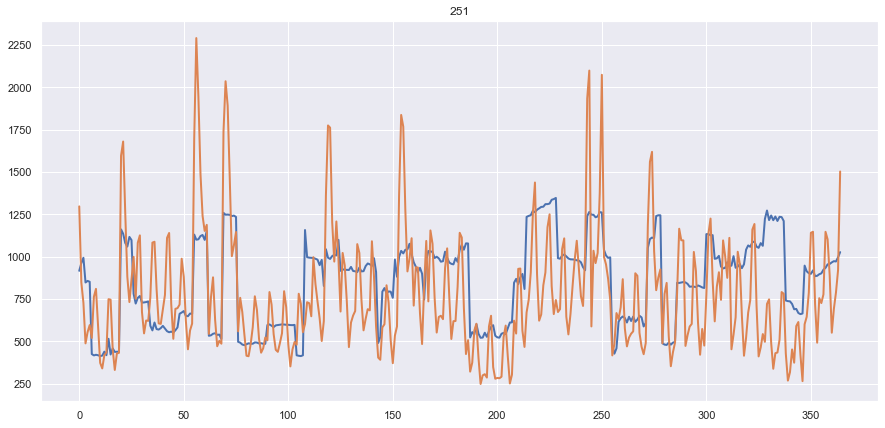

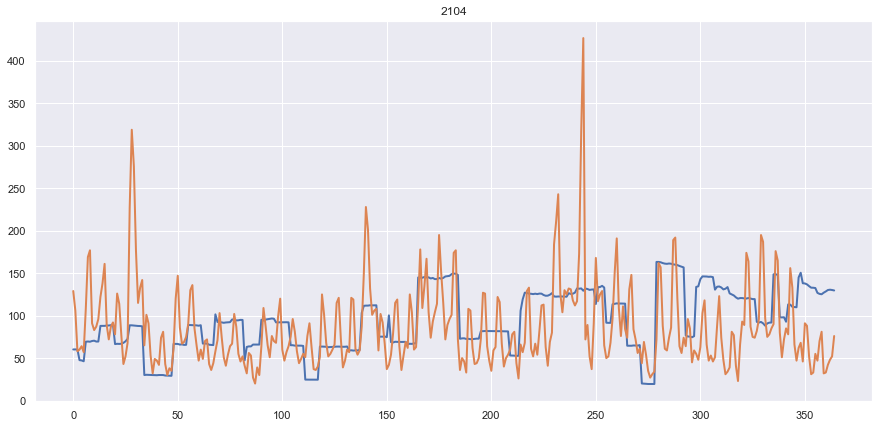

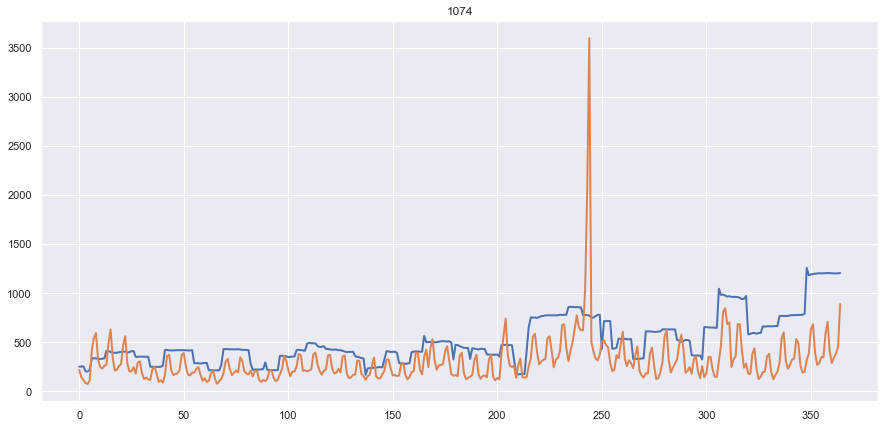

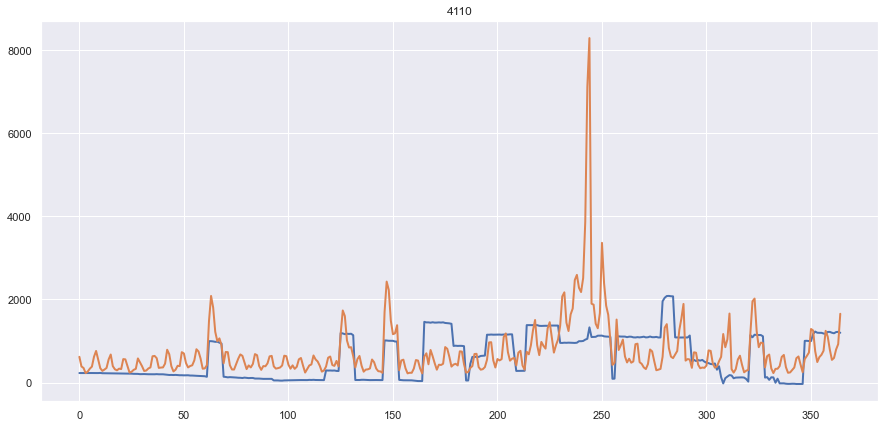

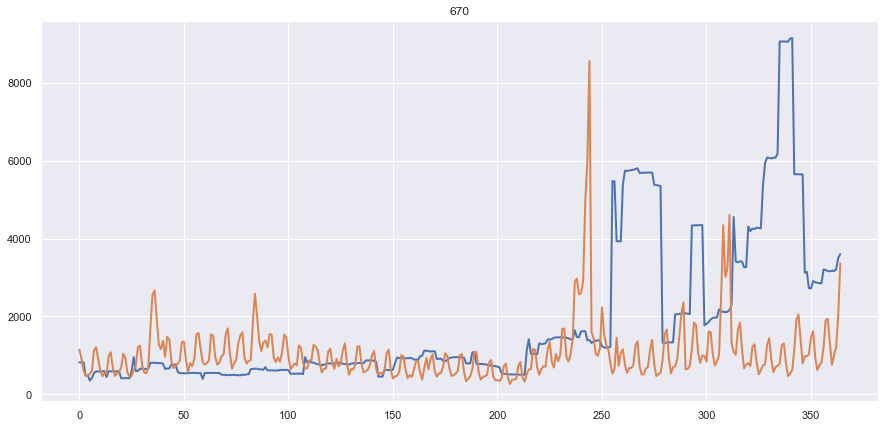

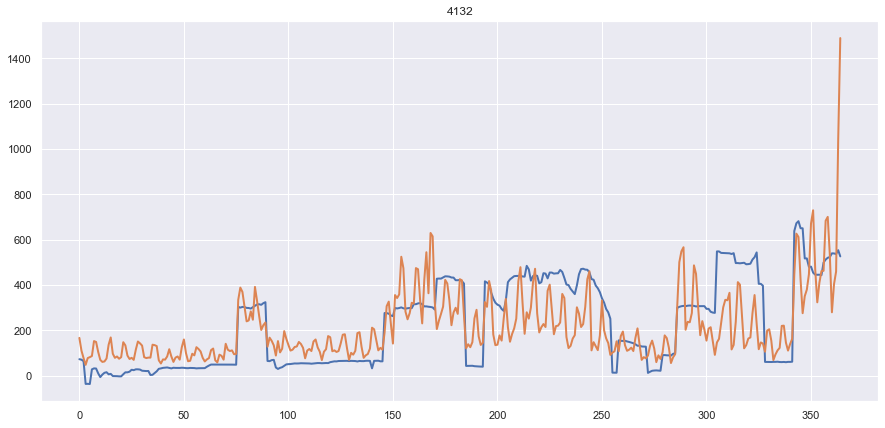

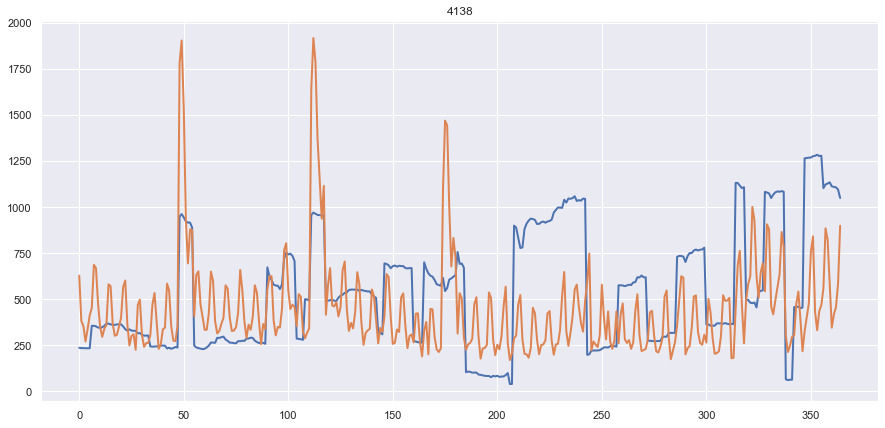

In [469]:
l = list(unique_CSB)
for x in l:
    plotModelResults1(final_df_lr[x], y_test=test_set[test_set['CSB'] == x]['total_quantity_sum'], plot_intervals=True, x = x)